# Geerts Arbitrator - Egocentric MF-SR

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
os.chdir(sys.path[0]+"/..")
cwd = os.getcwd()
print(cwd)

C:\Users\jrusp\Desktop\GitHub\mixed-coordination-models\sources


In [2]:
from grid_search import random_grid_search, compute_clusters_perfs, plot_two_perfs, plot_all_perfs, plot_local
from experimental_data import get_pearce_experimental_data, get_rodrigo_experimental_data
from pearce_protocol import perform_group_pearce, plot_pearce, create_path_main_pearce
from rodrigo_protocol import perform_group_rodrigo, create_path_rodrigo
from exp3_pearce_protocol import perform_group_exp3_pearce

from environments.HexWaterMaze import EnvironmentParams
from agents.agent import AgentsParams

import warnings
warnings.filterwarnings('ignore')

C:\Users\jrusp\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from pearce_protocol import create_path_main_pearce
from utils import create_df
import pandas as pd
import numpy as np
from utils import create_df
from statsmodels.formula.api import ols
import statsmodels.api as sm
import numpy as np

In [5]:
from utils import get_coords
coords = get_coords()

In [6]:
import math

def calculateDistance(p1,p2):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

p1 = coords[0]

lowest = 100
idlowest = -1
for i in range(0,271):

    p2 = coords[i]
    dist = calculateDistance((8,8),p2)
    if lowest > dist:
        lowest = dist
        idlowest = i
print(idlowest)



236


# Analyses

In [11]:
env_params = EnvironmentParams()
env_params.maze_size = 10
env_params.n_sessions = 11
env_params.n_trials = 4
env_params.n_agents = 100
env_params.init_sr = "zero"
env_params.landmark_dist = 4
env_params.time_limit = 500
env_params.starting_states = [243,230,270,257]

ag_params = AgentsParams()
ag_params.mf_allo = False
ag_params.hpc_lr = 0.088
ag_params.q_lr = 0.175
ag_params.inv_temp = 64
ag_params.gamma = 0.92
ag_params.eta = 0.03 # reliability learning rate
ag_params.alpha1 = 0.0001
ag_params.beta1 = 0.1
ag_params.A_alpha = 3.2 # Steepness of transition curve MF to SR
ag_params.A_beta = 1.1 # Steepness of transition curve SR to MF
ag_params.HPCmode = "SR"
ag_params.lesion_HPC = False
ag_params.lesion_DLS = False
ag_params.dolle = False

In [12]:
path = create_path_main_pearce(env_params, ag_params)

In [13]:
df = create_df(path, 100)

### Linear regression on P(SR), on session and trial

In [32]:
# LINEAR REGRESSION ON PSR

df2 = df.reset_index()
df2 = df2.pivot_table(index=['agent','session', 'trial'], aggfunc='mean')
df2["PSR"] = df2[["P(SR)"]]
df2 = df2.reset_index()
print(len(df2))

Y = df2["PSR"]
X = df2[["session", "trial"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

4400


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PSR   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 1.697e+04
Date:                Tue, 23 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:47:01   Log-Likelihood:                 6360.1
No. Observations:                4400   AIC:                        -1.271e+04
Df Residuals:                    4397   BIC:                        -1.269e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9602      0.002    485.065      0.000       0.956       0.964
session       -0.0500      0.000   -183.703      0.000      -0.050      -0.049
trial         -0.0109      0.001    -14.161      0.000      -0.012      -0.009
==============================================================================
Omnibus:                      138.973   Durbin-Watson:                   0.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.734
Skew:                          -0.269   Prob(JB):                     1.44e-52
Kurtosis:                       4.006   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Spatial pattern of P(SR)

In [263]:
from utils import get_coords
coords = get_coords()

In [264]:
import math

def calculateDistance(p1,p2):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

p1 = coords[0]

lowest = 100
idlowest = -1
for i in range(0,271):

    p2 = coords[i]
    dist = calculateDistance((8,8),p2)
    if lowest > dist:
        lowest = dist
        idlowest = i
print(idlowest)



236


#### Training the agents 4 trials with platform at state 126

In [87]:
from utils import charge_agents
from utils import get_mean_preferred_dirs
agents = charge_agents("../saved_results/"+path+"/agents.p")
_,_,_,_,p_sr, prevaMF, prevaSR, varmf, varsr = get_mean_preferred_dirs(agents, 126, 4)

#### Spatial patterns of P(SR)

In [88]:
df3 = df.groupby(by=["state"]).mean()
df3 = df3.reset_index()
df3 = df3["state"]
df3=df3.reset_index()

In [89]:
df3["distance"] = df3.apply(lambda row: calculateDistance(coords[126], coords[row.state]), axis=1)
df3["distance_group"] = df3.apply(lambda row: row.distance > 3, axis=1)

In [90]:
df3["PSR"] = p_sr
df3["prevaMF"] = prevaMF
df3["prevaSR"] = prevaSR
df3["varmf"] = varmf
df3["varsr"] = varsr

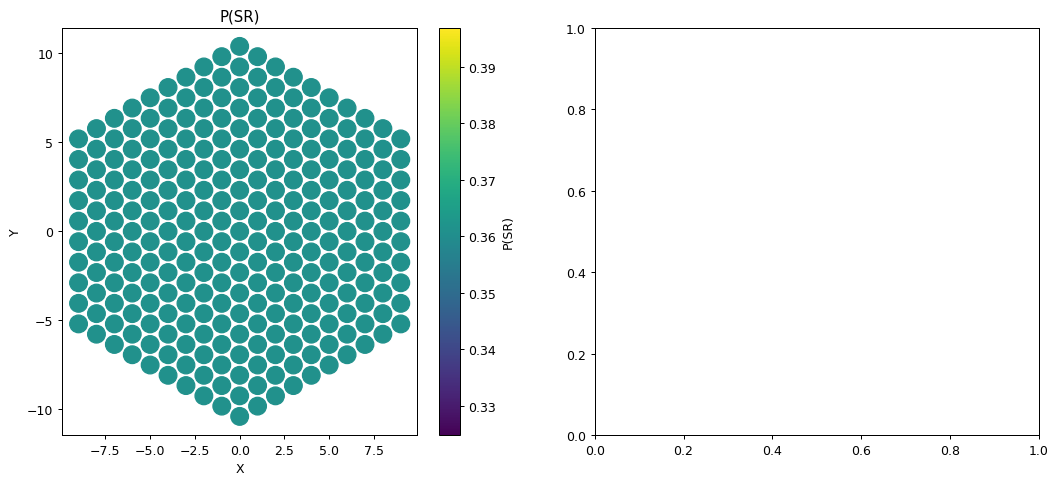

In [382]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(p_sr[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("P(SR)")
plt.colorbar(im, label="P(SR)",ax = axs[0])


In [377]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["PSR"], df3[df3["distance_group"]==True]["PSR"]))

Computing non parametric ANOVA on trial...


ValueError: All numbers are identical in kruskal

#### Spatial patterns of similarity of SR and MF to behavior

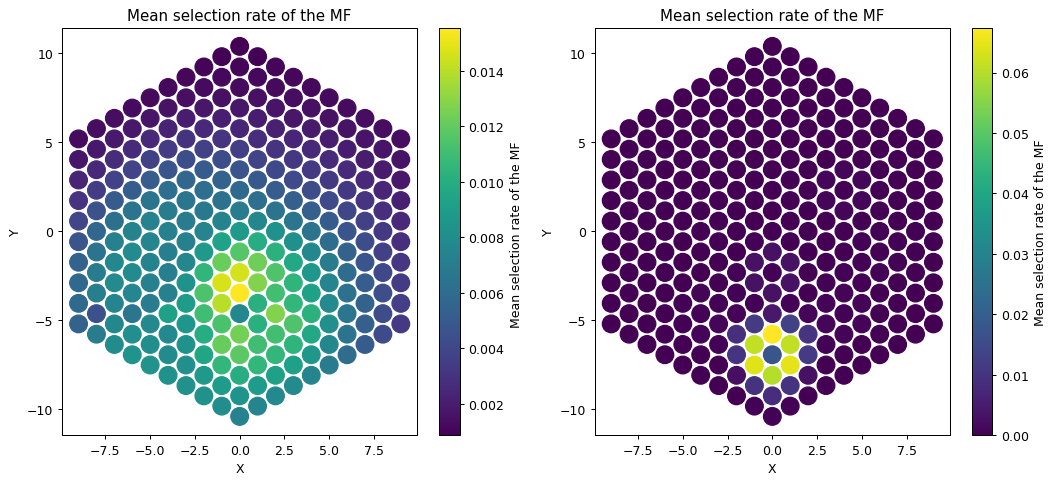

In [383]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varmf[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Variance in the MF actions values")
plt.colorbar(im, label="Variance in the MF actions values",ax = axs[0])



x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varsr[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

im = axs[1].scatter(x, y, 200, c=z)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Variance in the SR actions values")
plt.colorbar(im, label="Variance in the SR actions values",ax = axs[1])


In [92]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["varmf"], df3[df3["distance_group"]==True]["varmf"]))


Computing non parametric ANOVA on trial...
KruskalResult(statistic=25.63617952765111, pvalue=4.122373519510248e-07)


In [93]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["varsr"], df3[df3["distance_group"]==True]["varsr"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=52.808823529411825, pvalue=3.67645923668674e-13)


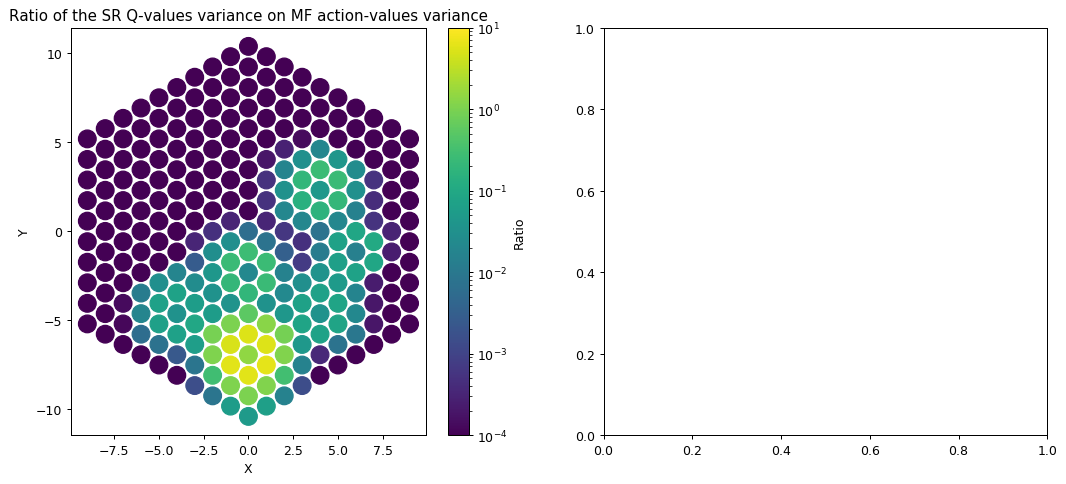

In [408]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varsr[cpt]/varmf[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z, norm=matplotlib.colors.LogNorm( 10, 0.0001))
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Ratio of the SR Q-values variance on MF action-values variance")
plt.colorbar(im, label="Ratio",ax = axs[0])



In [80]:
from scipy import stats
df3["difvar"] = df3["varsr"]/df3["varmf"]
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["difvar"], df3[df3["distance_group"]==True]["difvar"]))


Computing non parametric ANOVA on trial...
KruskalResult(statistic=52.808823529411825, pvalue=3.67645923668674e-13)


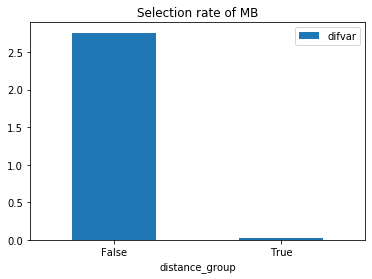

In [81]:
df3=df3.groupby(by=["distance_group"]).mean()
axes = df3[["difvar"]].plot.bar(title="Selection rate of MB", rot=0)

In [378]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["varmf"], df3[df3["distance_group"]==True]["varmf"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=36.74661518335272, pvalue=1.3452398144904819e-09)


In [379]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["varsr"], df3[df3["distance_group"]==True]["varsr"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=52.28073861123403, pvalue=4.810699347842461e-13)


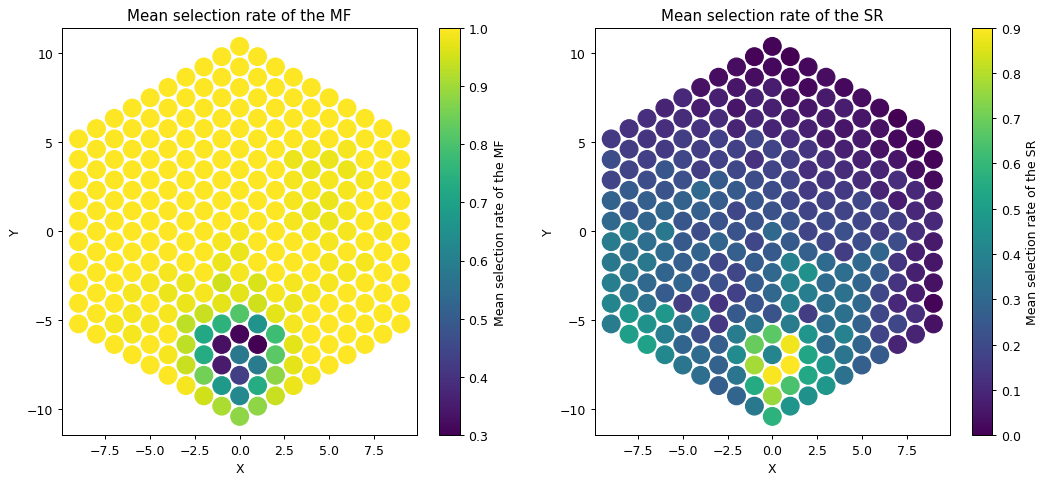

In [384]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(prevaMF[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Mean selection rate of the MF")
plt.colorbar(im, label="Mean selection rate of the MF",ax = axs[0])



x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(prevaSR[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

im = axs[1].scatter(x, y, 200, c=z)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Mean selection rate of the SR")
plt.colorbar(im, label="Mean selection rate of the SR",ax = axs[1])


In [380]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["prevaMF"], df3[df3["distance_group"]==True]["prevaMF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=77.10606462585704, pvalue=1.6201904747279406e-18)


In [381]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["prevaSR"], df3[df3["distance_group"]==True]["prevaSR"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=42.72190479413754, pvalue=6.310170378907093e-11)


In [94]:
_,_,_,_,p_sr, prevaMF, prevaSR, varmf, varsr = get_mean_preferred_dirs(agents, 48, 0)

In [60]:
df3 = df.groupby(by=["state"]).mean()
df3 = df3.reset_index()
df3 = df3["state"]
df3=df3.reset_index()

In [61]:
df3["distance"] = df3.apply(lambda row: calculateDistance(coords[126], coords[row.state]), axis=1)
df3["distance_group"] = df3.apply(lambda row: row.distance > 3, axis=1)

In [62]:
df3["PSR"] = p_sr
df3["prevaMF"] = prevaMF
df3["prevaSR"] = prevaSR
df3["varmf"] = varmf
df3["varsr"] = varsr

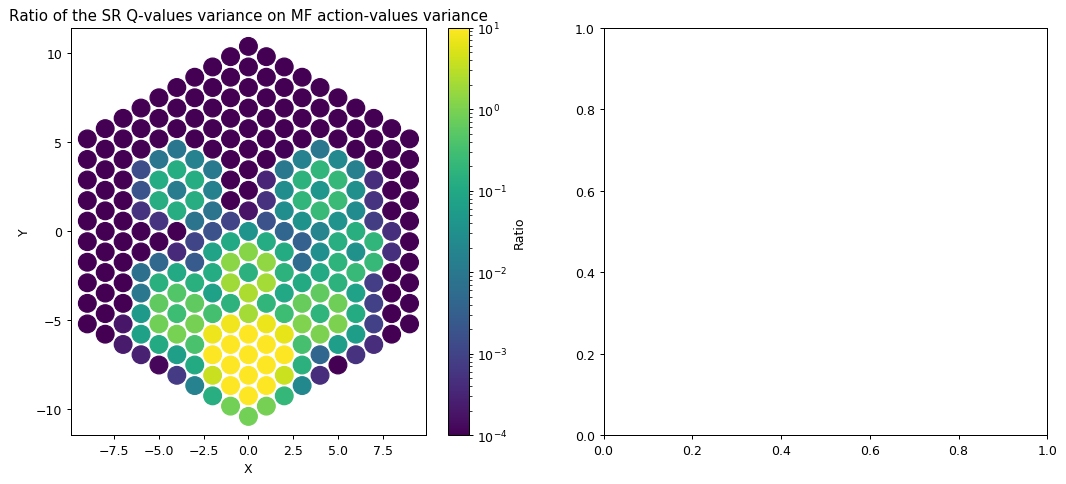

In [30]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varsr[cpt]/varmf[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z, norm=matplotlib.colors.LogNorm( 10, 0.0001))
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Ratio of the SR Q-values variance on MF action-values variance")
plt.colorbar(im, label="Ratio",ax = axs[0])



In [64]:
from scipy import stats
df3["difvar"] = df3["varsr"]/df3["varmf"]
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["difvar"], df3[df3["distance_group"]==True]["difvar"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=52.76471509656494, pvalue=3.7599574113354016e-13)


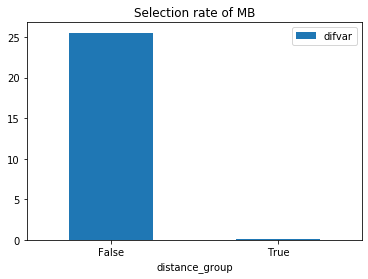

In [65]:
df3=df3.groupby(by=["distance_group"]).mean()
axes = df3[["difvar"]].plot.bar(title="Selection rate of MB", rot=0)

In [66]:
df3 = df.groupby(by=["state"]).mean()
df3 = df3.reset_index()
df3 = df3["state"]
df3=df3.reset_index()

In [67]:
df3["distance"] = df3.apply(lambda row: calculateDistance(coords[48], coords[row.state]), axis=1)
df3["distance_group"] = df3.apply(lambda row: row.distance > 3, axis=1)

In [68]:
df3["PSR"] = p_sr
df3["prevaMF"] = prevaMF
df3["prevaSR"] = prevaSR
df3["varmf"] = varmf
df3["varsr"] = varsr

In [69]:
from scipy import stats
df3["difvar"] = df3["varsr"]/df3["varmf"]
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["prevaMF"], df3[df3["distance_group"]==True]["prevaMF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=6.2719761812504435, pvalue=0.012266226271347241)


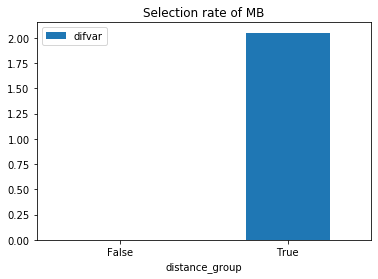

In [70]:
df3=df3.groupby(by=["distance_group"]).mean()
axes = df3[["difvar"]].plot.bar(title="Selection rate of MB", rot=0)

In [96]:
df3 = df.groupby(by=["state"]).mean()
df3 = df3.reset_index()
df3 = df3["state"]
df3=df3.reset_index()

df3["distance"] = df3.apply(lambda row: calculateDistance(coords[48], coords[row.state]), axis=1)
df3["distance_group"] = df3.apply(lambda row: row.distance > 3, axis=1)

df3["PSR"] = p_sr
df3["prevaMF"] = prevaMF
df3["prevaSR"] = prevaSR
df3["varmf"] = varmf
df3["varsr"] = varsr

In [98]:
from scipy import stats
df3["difvar"] = df3["varsr"]/df3["varmf"]
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df3[df3["distance_group"]==False]["prevaMF"], df3[df3["distance_group"]==True]["prevaMF"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=7.433363706147856, pvalue=0.0064025553236287955)


Text(0.5, 1.0, 'Variance Q-SR / Variance Q-MF')

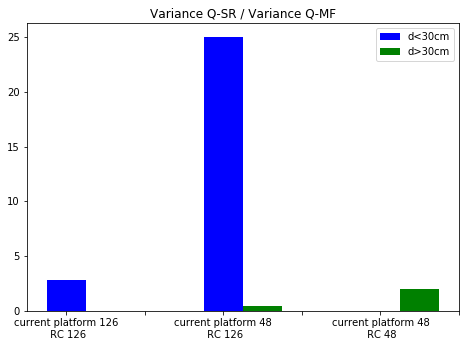

In [100]:
import numpy as np
import matplotlib.pyplot as plt
data = [[2.8, 25., 0.],
[0.05, 0.5, 2.],]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.set_xticklabels(['G1', 'current platform 126\n RC 126', '', 'current platform 48\n RC 126', '', "current platform 48\n RC 48"])
ax.legend(labels=['d<30cm', 'd>30cm'])
ax.set_title("Variance Q-SR / Variance Q-MF")

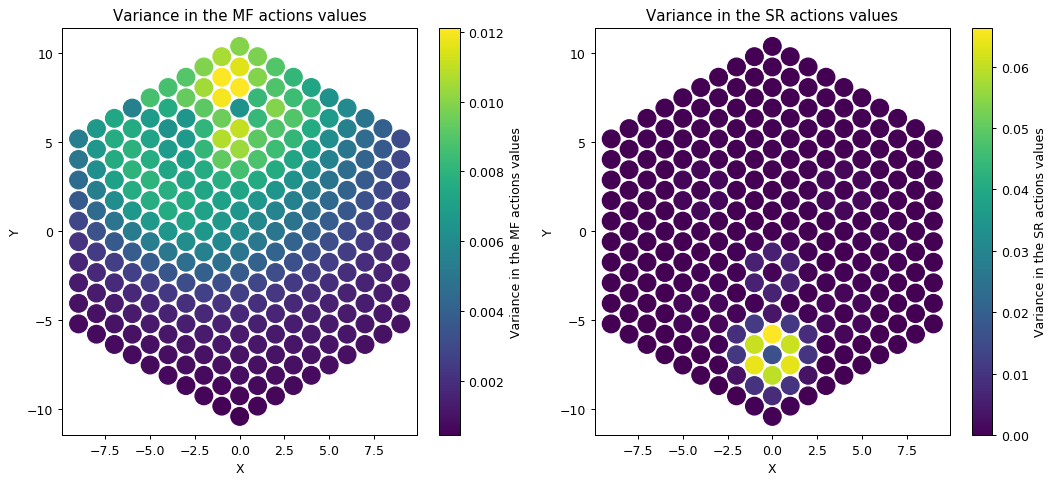

In [31]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varmf[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Variance in the MF actions values")
plt.colorbar(im, label="Variance in the MF actions values",ax = axs[0])



x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(varsr[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

im = axs[1].scatter(x, y, 200, c=z)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Variance in the SR actions values")
plt.colorbar(im, label="Variance in the SR actions values",ax = axs[1])


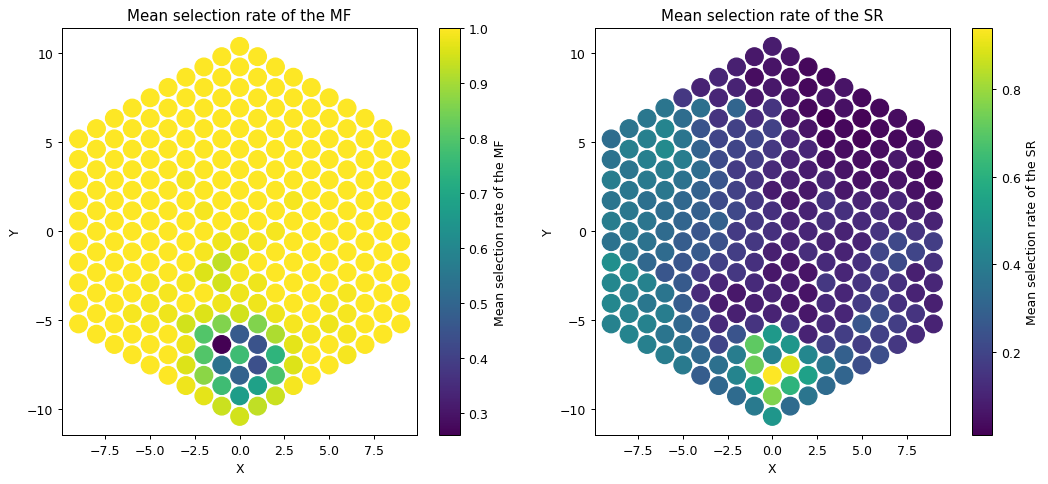

In [32]:
import matplotlib
from matplotlib import pyplot as plt

x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(prevaMF[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90)

im = axs[0].scatter(x, y, 200, c=z)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Mean selection rate of the MF")
plt.colorbar(im, label="Mean selection rate of the MF",ax = axs[0])



x = []
y = []
z = []
cpt=0
for i in df3.index:
    try:
        z.append(prevaSR[cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1

im = axs[1].scatter(x, y, 200, c=z)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("Mean selection rate of the SR")
plt.colorbar(im, label="Mean selection rate of the SR",ax = axs[1])


## Rodrigo - Normal model

In [6]:
env_params = EnvironmentParams()
env_params.maze_size = 10
env_params.n_agents = 100
env_params.init_sr = "zero"
env_params.landmark_dist = 0
env_params.time_limit = 500
env_params.starting_states = [243,230,270,257]

ag_params = AgentsParams()
ag_params.mf_allo = False
ag_params.hpc_lr = 0.069
ag_params.q_lr = 0.146
ag_params.inv_temp = 13
ag_params.gamma = 0.853
ag_params.eta = 0.03 # reliability learning rate
ag_params.alpha1 = 0.01
ag_params.beta1 = 0.1
ag_params.A_alpha = 3.2 # Steepness of transition curve MF to SR
ag_params.A_beta = 1.1 # Steepness of transition curve SR to MF
ag_params.HPCmode = "SR"
ag_params.lesion_HPC = False
ag_params.lesion_DLS = False
ag_params.dolle = False

In [7]:
from utils import get_coords
coords = get_coords()

In [8]:
from rodrigo_protocol import create_path_rodrigo
path = create_path_rodrigo(env_params, ag_params)

In [9]:
df = create_df(path, 100)

([<matplotlib.axis.XTick at 0x2892eff0a48>,
 <a list of 14 Text xticklabel objects>)

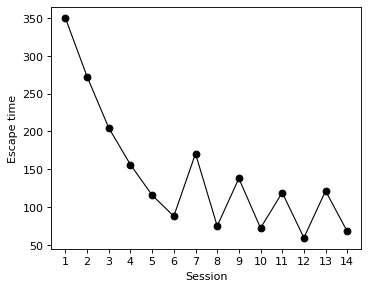

In [15]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby("session").mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["escape time"].plot(color="black", xlabel="Session", ylabel="Escape time", linewidth=1., marker="o")

df4 = df4.groupby("session").mean()
plt.xticks(range(1,15))



In [16]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="first"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     372.8
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           4.28e-59
Time:                        14:52:14   Log-Likelihood:                -2288.1
No. Observations:                 400   AIC:                             4580.
Df Residuals:                     398   BIC:                             4588.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        320.4021      6.189     51.770      0.000     308.235     332.569
session      -63.8758      3.308    -19.309      0.000     -70.379     -57.372
==============================================================================
Omnibus:                        2.334   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                2.173
Skew:                          -0.105   Prob(JB):                        0.337
Kurtosis:                       2.706   Cond. No.                         3.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# LINEAR REGRESSION ON ESCAPE TIME SECOND STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     34.81
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           4.97e-09
Time:                        14:52:17   Log-Likelihood:                -5455.6
No. Observations:                1000   AIC:                         1.092e+04
Df Residuals:                     998   BIC:                         1.092e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.2918      3.873     27.704      0.000      99.692     114.891
session       -3.6825      0.624     -5.900      0.000      -4.907      -2.458
==============================================================================
Omnibus:                      489.160   Durbin-Watson:                   1.577
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2522.982
Skew:                           2.285   Prob(JB):                         0.00
Kurtosis:                       9.298   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

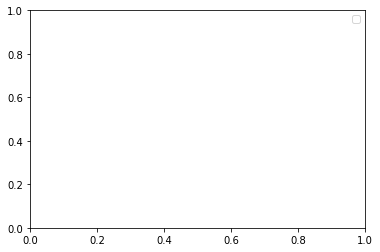

In [10]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

list_of_dataframes = []
for ang in [0,45,90,135,180]:
    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-ang), df3["angle"]==str(ang)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

    df2 = df2.reset_index()
    proximal_posx=df2.proximal_posx.iloc[0]
    proximal_posy=df2.proximal_posy.iloc[0]
    
    df2 = df2.groupby(["time", "agent"]).mean()
    df2 = df2.reset_index()
    df2["proximal_posx"] = float(proximal_posx)
    df2["proximal_posy"] = float(proximal_posy)
    df2["angle"] = abs(int(ang))

    plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

    def is_explo(previous_coord, coord, platform_coord):
        return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])


    
    df2["previous_coord"] = df2["state"]
    df2["has_reached_prox"] = 0
    for i in range(100):
        print(i)
        for t in range(1,250):
            ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
            ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]
            df2.loc[ilo2, "previous_coord"] = df2.loc[ilo1, "state"]

            if df2.loc[ilo2, 'isinoctant_proximal']:
                df2.loc[ilo2, "has_reached_prox"] = 1
            elif df2.loc[ilo1, "has_reached_prox"] == 1 or df2.loc[ilo1, "has_reached_prox"] == 2:
                df2.loc[ilo2, "has_reached_prox"] = 2
    #         if  df2.loc[ilo1, "has_reached_prox"] == 2:
    #             df2.loc[ilo2, "has_reached_prox"] = 2
    list_of_dataframes.append(df2)
df12 = pd.concat(list_of_dataframes)


In [11]:
from scipy.stats import entropy

df12["entro_mf"] = df12.apply(lambda row: entropy(np.array([row.Qprox0+row.Qdist0, row.Qprox1+row.Qdist1, row.Qprox2+row.Qdist2, row.Qprox3+row.Qdist3, row.Qprox4+row.Qdist4, row.Qprox5+row.Qdist5])), axis=1)
df12["var_prox"] = df12.apply(lambda row: np.array([row.Qprox0, row.Qprox1, row.Qprox2, row.Qprox3, row.Qprox4, row.Qprox5]).var(), axis=1)
df12["var_dist"] = df12.apply(lambda row: np.array([row.Qdist0, row.Qdist1, row.Qdist2, row.Qdist3, row.Qdist4, row.Qdist5]).var(), axis=1)
df12["var_sr"] = df12.apply(lambda row: np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5]).var(), axis=1)
df12["var_mf"] = df12.apply(lambda row: np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5]).var(), axis=1)

df7 = df12.groupby("state").mean()

In [12]:
def get_strategies(rew_func_sum, Qcombmf, Qcombsr, Qcombprox, Qcombdist, var_mf, var_sr):

    if Qcombmf and Qcombsr and var_mf>var_sr:
        if Qcombprox and Qcombdist:
            return "MF Both win"
        elif Qcombdist:
            return "MF Distal win"
        elif Qcombprox:
            return "MF Proximal win"

        else:
            return "MF Neither win"
        
    elif Qcombmf and Qcombsr and var_mf<var_sr:
        if rew_func_sum:
            return "SR platform"
        else:
            return "SR exploration"
    
    elif Qcombmf:
        if Qcombprox and Qcombdist:
            return "MF Both win"
        elif Qcombdist:
            return "MF Distal win"
        elif Qcombprox:
            return "MF Proximal win"

        else:
            return "MF Neither win"
        
    else:
        if rew_func_sum:
            return "SR platform"
        else:
            return "SR exploration"
        
    
df12["Strategies"] = df12.apply(lambda row: get_strategies(row.rew_func_sum, row.Qcombmf, row.Qcombsr, row.Qcombprox, row.Qcombdist, row.var_mf, row.var_sr), axis=1)

In [13]:
data2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["has_reached_prox", "Strategies", "angle"]).count()
data2 = data2["time"]/25100


In [14]:
data3=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data3 = data3["time"]/25100


In [15]:
data4=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data4 = data4["time"]/25100

In [16]:
data2 = data2.reset_index()
data2 = data2[data2["has_reached_prox"]==0]
data2 = data2.set_index(["angle", "Strategies"], drop=True).time

In [17]:
data3 = data3.reset_index()
data3 = data3[data3["has_reached_prox"]==1]
data3 = data3.set_index(["angle", "Strategies"], drop=True).time

In [18]:
data4 = data4.reset_index()
data4 = data4[data4["has_reached_prox"]==2]
data4 = data4.set_index(["angle", "Strategies"], drop=True).time

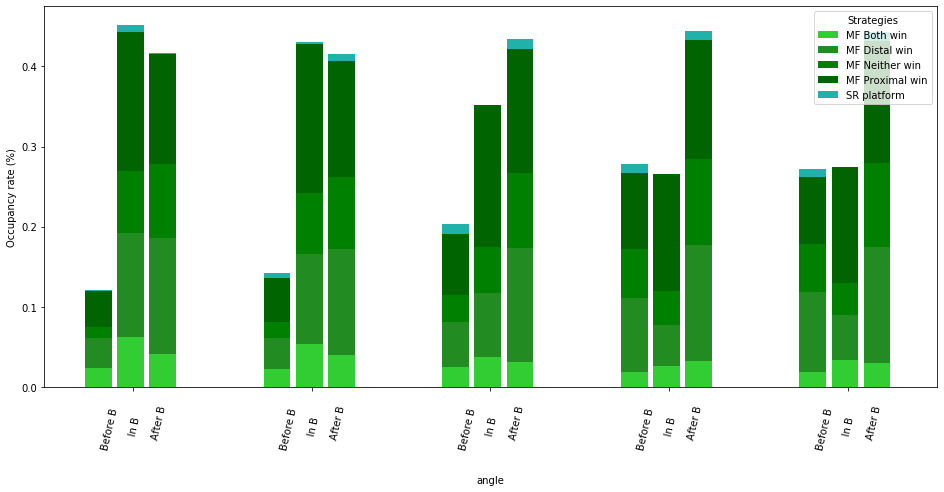

In [41]:
fig, ax = plt.subplots(figsize=(16,7))
#data2["time"].plot(kind='bar', position=1, ax=ax)


data2.unstack().plot(kind='bar', position=1.8, ax=ax, legend=False,stacked=True,width=0.15, color=['limegreen', 'forestgreen','green', "darkgreen","lightseagreen","darkslateblue"])
data3.unstack().plot(kind='bar', position=0.6, ax=ax, legend=False,stacked=True,width=0.15,color=['limegreen', 'forestgreen', 'green',"darkgreen","lightseagreen","darkslateblue"])
data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15, color=['limegreen', 'forestgreen', 'green',"darkgreen","lightseagreen","darkslateblue"])

ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=77)
ax.set_ylabel("Occupancy rate (%)")
plt.xlim((-0.5, len(data4)/5-0.5));

In [19]:
from scipy import stats

df2 = data2.unstack().sum(axis=1)
df2 = df2.reset_index()

df5 = data3.unstack().sum(axis=1)
df5 = df5.reset_index()
stats.pearsonr(df2[0],df5[0])

(-0.9995949457929211, 9.78536860419139e-06)

In [20]:
from scipy import stats

df2 = data3.unstack().sum(axis=1)
df2 = df2.reset_index()

df5 = data4.unstack().sum(axis=1)
df5 = df5.reset_index()
stats.pearsonr(df2[0],df5[0])

(-0.9862937699697027, 0.0019222770627182987)

In [21]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = data2.unstack().sum(axis=1)
df2 = df2.reset_index()


Y = df2[0]
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     36.13
Date:                Tue, 21 Dec 2021   Prob (F-statistic):            0.00923
Time:                        21:51:00   Log-Likelihood:                 13.022
No. Observations:                   5   AIC:                            -22.04
Df Residuals:                       3   BIC:                            -22.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1154      0.018      6.448      0.008       0.058       0.172
angle          0.0010      0.000      6.011      0.009       0.000       0.001
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.593
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.478
Skew:                           0.619   Prob(JB):                        0.787
Kurtosis:                       2.129   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = data3.unstack().sum(axis=1)
df2 = df2.reset_index()


Y = df2[0]
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     32.12
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0109
Time:                        21:51:04   Log-Likelihood:                 11.868
No. Observations:                   5   AIC:                            -19.74
Df Residuals:                       3   BIC:                            -20.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4592      0.023     20.375      0.000       0.387       0.531
angle         -0.0012      0.000     -5.667      0.011      -0.002      -0.001
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.549
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.399
Skew:                          -0.453   Prob(JB):                        0.819
Kurtosis:                       1.954   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = data4.unstack().sum(axis=1)
df2 = df2.reset_index()


Y = df2[0]
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     16.57
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0268
Time:                        21:51:12   Log-Likelihood:                 19.453
No. Observations:                   5   AIC:                            -34.91
Df Residuals:                       3   BIC:                            -35.69
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4140      0.005     83.747      0.000       0.398       0.430
angle          0.0002   4.49e-05      4.070      0.027    3.98e-05       0.000
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.567
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.557
Skew:                          -0.330   Prob(JB):                        0.757
Kurtosis:                       1.504   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### In function of angle

In [43]:
df12["distwin"]=np.logical_and(np.logical_and(df12["Qcombmf"]==1, df12["Qcombprox"]==0), df12["Qcombdist"]==1)
df12["proxwin"]=np.logical_and(np.logical_and(df12["Qcombmf"]==1, df12["Qcombprox"]==1), df12["Qcombdist"]==0)

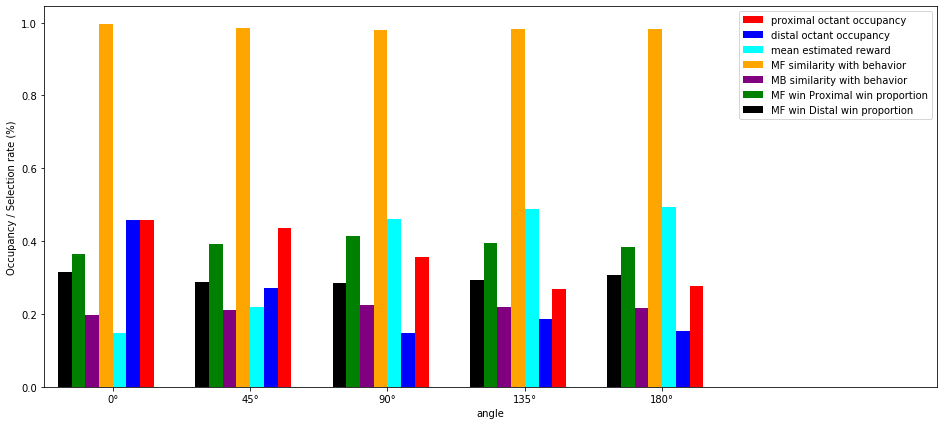

In [67]:
fig, ax = plt.subplots(figsize=(16,7))
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['isinoctant_proximal'].plot(position=-2, kind="bar", width=0.1, color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['isinoctant_distal'].plot(position=-1, kind="bar", width=0.1,color="b")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['rew_func_sum'].plot(position=0, kind="bar", width=0.1,color="cyan")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombmf'].plot(position=1, kind="bar", width=0.1, color="orange")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombsr'].plot(position=2, kind="bar", width=0.1, color="purple")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['proxwin'].plot(position=3, kind="bar", width=0.1, color="green")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['distwin'].plot(position=4, kind="bar", width=0.1, color="black")
#df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombmf'].plot(position=2, kind="bar", width=0.1,color="green")
ax.set_xticklabels(["0°", "45°", "90°", "135°", "180°"], rotation=0)
ax.set_ylabel("Occupancy / Selection rate (%)")
plt.xlim((-0.5, 6.5-0.5));
plt.legend(["proximal octant occupancy", "distal octant occupancy", "mean estimated reward", "MF similarity with behavior", "MB similarity with behavior","MF win Proximal win proportion", "MF win Distal win proportion"])

In [46]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["agent", "angle"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_proximal']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     isinoctant_proximal   R-squared:                       0.155
Model:                             OLS   Adj. R-squared:                  0.153
Method:                  Least Squares   F-statistic:                     91.18
Date:                 Tue, 21 Dec 2021   Prob (F-statistic):           5.92e-20
Time:                         17:07:55   Log-Likelihood:                 163.86
No. Observations:                  500   AIC:                            -323.7
Df Residuals:                      498   BIC:                            -315.3
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4642      0.014     34.299      0.000       0.438       0.491
angle         -0.0012      0.000     -9.549      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        5.457   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                4.927
Skew:                           0.181   Prob(JB):                       0.0852
Kurtosis:                       2.675   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_distal']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      isinoctant_distal   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     180.5
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           2.51e-35
Time:                        17:07:56   Log-Likelihood:                 198.45
No. Observations:                 500   AIC:                            -392.9
Df Residuals:                     498   BIC:                            -384.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3816      0.013     30.219      0.000       0.357       0.406
angle         -0.0015      0.000    -13.433      0.000      -0.002      -0.001
==============================================================================
Omnibus:                       39.557   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.779
Skew:                           0.714   Prob(JB):                     6.95e-11
Kurtosis:                       3.451   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[ np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()

df2 = df2.reset_index()


Y = df2['rew_func_sum']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rew_func_sum   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     98.85
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           2.29e-21
Time:                        17:08:03   Log-Likelihood:                -114.85
No. Observations:                 500   AIC:                             233.7
Df Residuals:                     498   BIC:                             242.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1701      0.024      7.199      0.000       0.124       0.217
angle          0.0021      0.000      9.942      0.000       0.002       0.003
==============================================================================
Omnibus:                       30.309   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.055
Skew:                           0.501   Prob(JB):                     1.33e-06
Kurtosis:                       2.458   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['Qcombmf']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombmf   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     25.61
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           5.90e-07
Time:                        17:08:29   Log-Likelihood:                 1272.5
No. Observations:                 500   AIC:                            -2541.
Df Residuals:                     498   BIC:                            -2533.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9908      0.001    672.341      0.000       0.988       0.994
angle      -6.765e-05   1.34e-05     -5.060      0.000   -9.39e-05   -4.14e-05
==============================================================================
Omnibus:                      725.836   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           202173.607
Skew:                          -7.556   Prob(JB):                         0.00
Kurtosis:                     100.345   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()

df2 = df2.reset_index()


Y = df2['Qcombsr']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombsr   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     5.816
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0162
Time:                        17:08:42   Log-Likelihood:                 663.29
No. Observations:                 500   AIC:                            -1323.
Df Residuals:                     498   BIC:                            -1314.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2040      0.005     40.940      0.000       0.194       0.214
angle          0.0001   4.52e-05      2.412      0.016    2.02e-05       0.000
==============================================================================
Omnibus:                       14.002   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.395
Skew:                           0.405   Prob(JB):                     0.000749
Kurtosis:                       3.189   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['distwin']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                distwin   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4595
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.498
Time:                        17:08:49   Log-Likelihood:                 678.23
No. Observations:                 500   AIC:                            -1352.
Df Residuals:                     498   BIC:                            -1344.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3004      0.005     62.109      0.000       0.291       0.310
angle      -2.975e-05   4.39e-05     -0.678      0.498      -0.000    5.65e-05
==============================================================================
Omnibus:                       12.466   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.923
Skew:                           0.308   Prob(JB):                     0.000948
Kurtosis:                       3.539   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['proxwin']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                proxwin   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.463
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0634
Time:                        17:08:59   Log-Likelihood:                 624.88
No. Observations:                 500   AIC:                            -1246.
Df Residuals:                     498   BIC:                            -1237.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3814      0.005     70.858      0.000       0.371       0.392
angle       9.086e-05   4.88e-05      1.861      0.063   -5.07e-06       0.000
==============================================================================
Omnibus:                        4.500   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.355
Skew:                          -0.185   Prob(JB):                        0.113
Kurtosis:                       3.268   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### In function of time

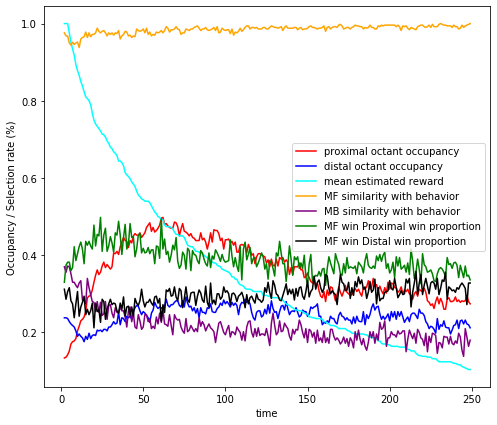

In [66]:
fig, ax = plt.subplots(figsize=(8,7))
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['isinoctant_proximal'].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['isinoctant_distal'].plot(color="b")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['rew_func_sum'].plot(color="cyan")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['Qcombmf'].plot(color="orange")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['Qcombsr'].plot(color="purple")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['proxwin'].plot(color="green")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['distwin'].plot(color="black")

#df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombmf'].plot(position=2, kind="bar", width=0.1,color="green")
#ax.set_xticklabels(["0°", "45°", "90°", "135°", "180°"], rotation=0)
ax.set_ylabel("Occupancy / Selection rate (%)")
#plt.xlim((-0.5, 5.5-0.5));
plt.legend(["proximal octant occupancy", "distal octant occupancy", "mean estimated reward", "MF similarity with behavior", "MB similarity with behavior","MF win Proximal win proportion", "MF win Distal win proportion"])

In [56]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_proximal']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     isinoctant_proximal   R-squared:                       0.155
Model:                             OLS   Adj. R-squared:                  0.151
Method:                  Least Squares   F-statistic:                     44.98
Date:                 Tue, 21 Dec 2021   Prob (F-statistic):           1.35e-10
Time:                         17:10:52   Log-Likelihood:                 299.72
No. Observations:                  248   AIC:                            -595.4
Df Residuals:                      246   BIC:                            -588.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4128      0.009     44.399      0.000       0.395       0.431
time          -0.0004   6.44e-05     -6.707      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       80.946   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.935
Skew:                          -1.490   Prob(JB):                     4.27e-46
Kurtosis:                       6.367   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_distal']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      isinoctant_distal   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1403
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.708
Time:                        17:10:57   Log-Likelihood:                 572.13
No. Observations:                 248   AIC:                            -1140.
Df Residuals:                     246   BIC:                            -1133.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2441      0.003     78.744      0.000       0.238       0.250
time       -8.037e-06   2.15e-05     -0.375      0.708   -5.03e-05    3.42e-05
==============================================================================
Omnibus:                        9.082   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.270
Skew:                          -0.445   Prob(JB):                      0.00971
Kurtosis:                       2.676   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[ np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()

df2 = df2.reset_index()


Y = df2['rew_func_sum']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rew_func_sum   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1812.
Date:                Tue, 21 Dec 2021   Prob (F-statistic):          1.80e-115
Time:                        17:11:01   Log-Likelihood:                 285.65
No. Observations:                 248   AIC:                            -567.3
Df Residuals:                     246   BIC:                            -560.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7258      0.010     73.757      0.000       0.706       0.745
time          -0.0029   6.81e-05    -42.572      0.000      -0.003      -0.003
==============================================================================
Omnibus:                       62.678   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.709
Skew:                           1.329   Prob(JB):                     2.03e-25
Kurtosis:                       4.984   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['Qcombmf']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombmf   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     338.9
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           3.57e-48
Time:                        17:11:13   Log-Likelihood:                 884.72
No. Observations:                 248   AIC:                            -1765.
Df Residuals:                     246   BIC:                            -1758.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9706      0.001   1104.351      0.000       0.969       0.972
time           0.0001   6.08e-06     18.410      0.000       0.000       0.000
==============================================================================
Omnibus:                       73.098   Durbin-Watson:                   0.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.178
Skew:                          -1.275   Prob(JB):                     1.88e-47
Kurtosis:                       6.784   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['Qcombsr']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombsr   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     354.5
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           1.42e-49
Time:                        17:11:25   Log-Likelihood:                 545.45
No. Observations:                 248   AIC:                            -1087.
Df Residuals:                     246   BIC:                            -1080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2703      0.003     78.308      0.000       0.264       0.277
time          -0.0004   2.39e-05    -18.827      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       55.575   Durbin-Watson:                   0.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.748
Skew:                           1.155   Prob(JB):                     2.96e-23
Kurtosis:                       5.168   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()

df2 = df2.reset_index()


Y = df2['proxwin']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                proxwin   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     159.3
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           1.72e-28
Time:                        17:11:37   Log-Likelihood:                 551.49
No. Observations:                 248   AIC:                            -1099.
Df Residuals:                     246   BIC:                            -1092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4265      0.003    126.592      0.000       0.420       0.433
time          -0.0003   2.33e-05    -12.621      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        6.354   Durbin-Watson:                   1.411
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                9.806
Skew:                           0.054   Prob(JB):                      0.00743
Kurtosis:                       3.968   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['distwin']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                distwin   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     177.8
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           6.90e-31
Time:                        17:11:42   Log-Likelihood:                 621.98
No. Observations:                 248   AIC:                            -1240.
Df Residuals:                     246   BIC:                            -1233.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2684      0.003    105.861      0.000       0.263       0.273
time           0.0002   1.75e-05     13.333      0.000       0.000       0.000
==============================================================================
Omnibus:                        1.183   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.553   Jarque-Bera (JB):                0.914
Skew:                          -0.130   Prob(JB):                        0.633
Kurtosis:                       3.145   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

([<matplotlib.axis.XTick at 0x2892edccd88>,
 <a list of 14 Text xticklabel objects>)

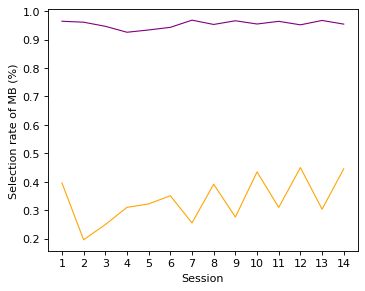

In [65]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby(["session", "agent"]).mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["Qcombsr"].plot(color="orange", xlabel="Session", ylabel="Selection rate of MB (%)", linewidth=1.)
df4["Qcombmf"].plot(color="purple", xlabel="Session", ylabel="Selection rate of MB (%)", linewidth=1.)

plt.xticks(range(1,15))



In [69]:
from scipy import stats
#PROXIMAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df4[df4["session"]<7]["Qcombmf"], df4[df4["session"]>=7]["Qcombmf"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=1.1795918367346871, pvalue=0.27743910513984543)


In [70]:
from scipy import stats
#PROXIMAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df4[df4["session"]<7]["Qcombsr"], df4[df4["session"]>=7]["Qcombsr"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=2.1591836734693857, pvalue=0.14171996321058591)


In [71]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
#df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle"]).mean()

df4 = df4.reset_index()


Y = df4['Qcombmf']
X = df4[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombmf   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.108
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.313
Time:                        17:15:28   Log-Likelihood:                 42.131
No. Observations:                  14   AIC:                            -80.26
Df Residuals:                      12   BIC:                            -78.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9483      0.007    145.062      0.000       0.934       0.963
session        0.0009      0.001      1.053      0.313      -0.001       0.003
==============================================================================
Omnibus:                        0.833   Durbin-Watson:                   1.329
Prob(Omnibus):                  0.659   Jarque-Bera (JB):                0.735
Skew:                          -0.461   Prob(JB):                        0.692
Kurtosis:                       2.359   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
#df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle"]).mean()

#df4 = df4.reset_index()


Y = df4['Qcombsr']
X = df4[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombsr   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     3.529
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0848
Time:                        17:15:52   Log-Likelihood:                 17.961
No. Observations:                  14   AIC:                            -31.92
Df Residuals:                      12   BIC:                            -30.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2764      0.037      7.523      0.000       0.196       0.356
session        0.0090      0.005      1.879      0.085      -0.001       0.019
==============================================================================
Omnibus:                        2.846   Durbin-Watson:                   3.032
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                1.101
Skew:                           0.130   Prob(JB):                        0.577
Kurtosis:                       1.651   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Evolution of MF weights

In [77]:
df12["distance_prox"] = df12.apply(lambda row: calculateDistance((row.proximal_posx, row.proximal_posy), coords[row.state]), axis=1)
df12["distance_dist"] = df12.apply(lambda row: calculateDistance(coords[90], coords[row.state]), axis=1)
df12["distance_prox"] = df12["distance_prox"].astype(int)
df12["distance_dist"] = df12["distance_dist"].astype(int)

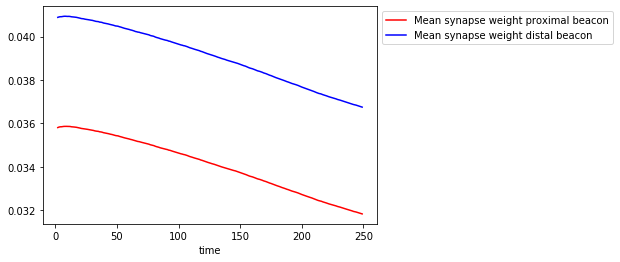

In [78]:
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_prox_mean"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_dist_mean"].plot(color="b")
plt.legend(["Mean synapse weight proximal beacon", "Mean synapse weight distal beacon"],  bbox_to_anchor=(1.0, 1.0))

In [79]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("agent").mean()["syn_dist_mean"], df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("agent").mean()["syn_prox_mean"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=149.13435223880595, pvalue=2.680237432416444e-34)


Evolution of DIST/PROX selection rate and variance

Text(0, 0.5, 'Selection rate (%)')

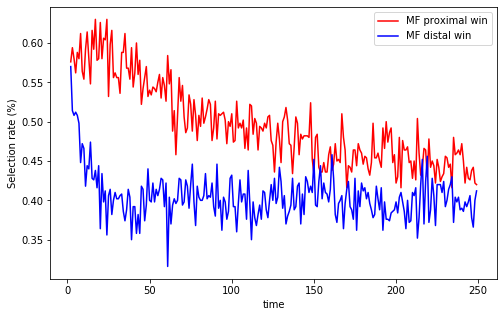

In [80]:
fig, ax = plt.subplots(figsize=(8,5))
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["Qcombprox"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["Qcombdist"].plot(color="b")
plt.legend(["MF proximal win", "MF distal win"],  bbox_to_anchor=(1.0, 1.0))
ax.set_ylabel("Selection rate (%)")

In [81]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>50, df12["time"]<250)].groupby("agent").mean()["Qcombprox"], df12[np.logical_and(df12["time"]>50, df12["time"]<250)].groupby("agent").mean()["Qcombdist"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=118.87563692334919, pvalue=1.1150581811806486e-27)


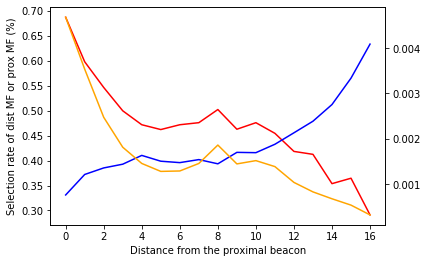

In [82]:
fig, ax = plt.subplots(1, 1)
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()["Qcombprox"].plot(ax=ax, color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()["Qcombdist"].plot(ax=ax, color="b")
#plt.legend(["proximal octant", "distal octant", "mean reward", "SR win", "MF win"],  bbox_to_anchor=(1.0, 1.0))
ax2 = ax.twinx()
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()["var_prox"].plot(ax=ax2,color="orange")

ax.set_ylabel("Selection rate of dist MF or prox MF (%)")
ax.set_xlabel("Distance from the proximal beacon")
#plt.legend(["proximal octant", "distal octant", "mean reward", "SR win", "MF win"],  bbox_to_anchor=(1.0, 1.0))

plt.draw()

In [83]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df14 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()
df14=df14.reset_index()

Y = df14["Qcombprox"]
X = df14["distance_prox"]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Qcombprox   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     61.55
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           1.09e-06
Time:                        17:18:19   Log-Likelihood:                 30.907
No. Observations:                  17   AIC:                            -57.81
Df Residuals:                      15   BIC:                            -56.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5973      0.019     30.755      0.000       0.556       0.639
distance_prox    -0.0162      0.002     -7.845      0.000      -0.021      -0.012
==============================================================================
Omnibus:                        0.297   Durbin-Watson:                   0.696
Prob(Omnibus):                  0.862   Jarque-Bera (JB):                0.321
Skew:                           0.255   Prob(JB):                        0.852
Kurtosis:                       2.562   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df14 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()
df14=df14.reset_index()

Y = df14["Qcombdist"]
X = df14["distance_prox"]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Qcombdist   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     47.43
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           5.17e-06
Time:                        17:18:24   Log-Likelihood:                 32.516
No. Observations:                  17   AIC:                            -61.03
Df Residuals:                      15   BIC:                            -59.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3309      0.018     18.728      0.000       0.293       0.369
distance_prox     0.0130      0.002      6.887      0.000       0.009       0.017
==============================================================================
Omnibus:                        4.310   Durbin-Watson:                   0.357
Prob(Omnibus):                  0.116   Jarque-Bera (JB):                2.290
Skew:                           0.867   Prob(JB):                        0.318
Kurtosis:                       3.474   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df14 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()
df14=df14.reset_index()
df14["var_prox"] = df14["var_prox"]*200

Y = df14["var_prox"]
X = df14["distance_prox"]

X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               var_prox   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     31.81
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           4.70e-05
Time:                        17:18:29   Log-Likelihood:                 12.013
No. Observations:                  17   AIC:                            -20.03
Df Residuals:                      15   BIC:                            -18.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6090      0.059     10.319      0.000       0.483       0.735
distance_prox    -0.0355      0.006     -5.640      0.000      -0.049      -0.022
==============================================================================
Omnibus:                        5.071   Durbin-Watson:                   0.433
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                2.501
Skew:                           0.737   Prob(JB):                        0.286
Kurtosis:                       4.166   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Variance')

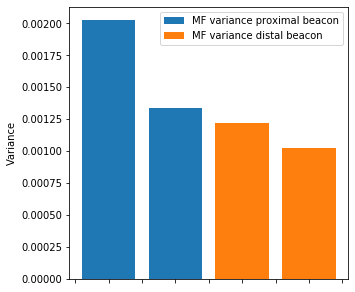

In [86]:

fig, ax = plt.subplots(figsize=(5,5))
plt.bar(x=[1,2], height=[df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby("state").mean()["var_prox"].mean(),df12[np.logical_and(df12["time"]>125, df12["time"]<250)].groupby("state").mean()["var_prox"].mean()])

plt.bar(x=[3,4], height=[df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby("state").mean()["var_dist"].mean(),df12[np.logical_and(df12["time"]>125, df12["time"]<250)].groupby("state").mean()["var_dist"].mean()])
#ax.legend(labels=['Proximal MF'], bbox_to_anchor=(1., 1.2))
plt.legend(["MF variance proximal beacon", "MF variance distal beacon"],  bbox_to_anchor=(1.0, 1.0))
ax.set_xticklabels(["", "", "", ""], rotation=70)
ax.set_ylabel("Variance")

In [87]:
from scipy import stats
#PROXIMAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_prox"], df12[np.logical_and(df12["time"]>1, df12["time"]>125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_prox"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=113.69848358208958, pvalue=1.517090774376102e-26)


In [88]:
from scipy import stats
# DISTAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_dist"], df12[np.logical_and(df12["time"]>1, df12["time"]>125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_dist"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=49.3813492537314, pvalue=2.1073969826341044e-12)


#### MF Variance NEAR DISTAL/PROXIMAL

In [98]:
from scipy.stats import entropy
df12["var_prox"] = df12.apply(lambda row: np.array([row.Qprox0, row.Qprox1, row.Qprox2, row.Qprox3, row.Qprox4, row.Qprox5]).var(), axis=1)
df12["var_dist"] = df12.apply(lambda row: np.array([row.Qdist0, row.Qdist1, row.Qdist2, row.Qdist3, row.Qdist4, row.Qdist5]).var(), axis=1)


In [99]:
df12["distance1"] = df12.apply(lambda row: calculateDistance(coords[75], coords[row.state]), axis=1)
df12["distance_group1"] = df12.apply(lambda row: row.distance1 > 3, axis=1)
df12["distance_group1"]=df12['distance_group1'].replace([True, False], ["d>30cm", 'd<30cm'])

In [100]:
df3=df12
df7 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby("state").mean()
df8 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby(["state", "distance_group1"]).mean()

In [101]:
# number of state where variance SR > variance MF
df7["ratio_prox_dist"] = df7["var_prox"]/df7["var_dist"]
df7[df7["ratio_prox_dist"] < 1]["ratio_prox_dist"].count()
df8["ratio_prox_dist"] = df8["var_prox"]/df8["var_dist"]
df8[df8["ratio_prox_dist"] < 1]["ratio_prox_dist"].count()

138

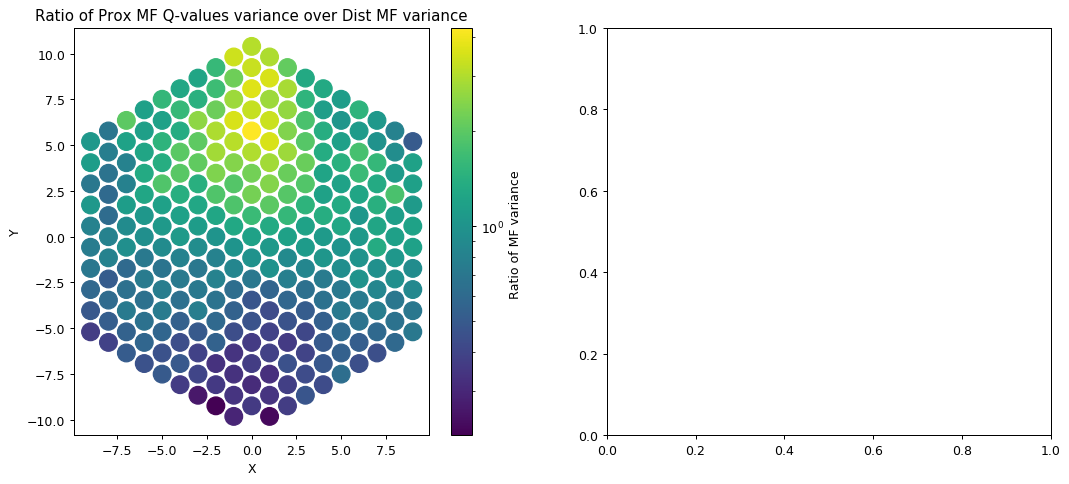

In [102]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["var_prox"][cpt]/df7["var_dist"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z, norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Ratio of Prox MF Q-values variance over Dist MF variance")
plt.colorbar(im, label="Ratio of MF variance ",ax = axs[0])


In [103]:
from scipy import stats
df8=df8.reset_index()
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df8[df8["distance_group1"]=="d>30cm"]["ratio_prox_dist"], df8[df8["distance_group1"]=="d<30cm"]["ratio_prox_dist"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=48.95533871443308, pvalue=2.618575366434572e-12)


#### MF ENTROPY NEAR DISTAL/PROXIMAL

In [104]:
df12["distance2"] = df12.apply(lambda row: calculateDistance(coords[75], coords[row.state]), axis=1)
df12["distance_group2"] = df12.apply(lambda row: row.distance2 > 3, axis=1)
df12["distance_group2"]=df12['distance_group2'].replace([True, False], ["d>30cm", 'd<30cm'])

In [105]:
df3=df12
df7 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby("state").mean()
df8 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby(["state", "distance_group2"]).mean()

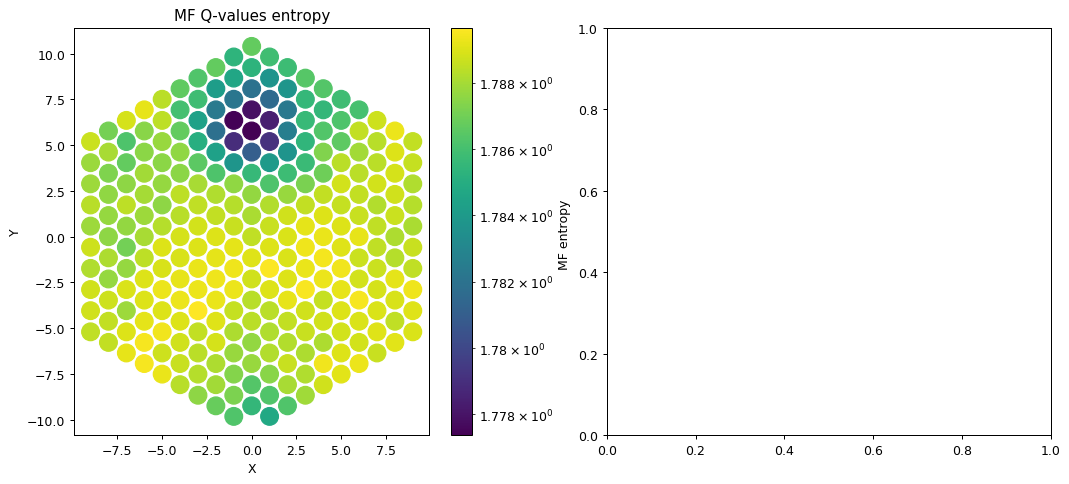

In [106]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["entro_mf"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z, norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values entropy")
plt.colorbar(im, label="MF entropy ",ax = axs[0])


In [107]:
from scipy import stats
df8=df8.reset_index()
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df8[df8["distance_group2"]=="d>30cm"]["entro_mf"], df8[df8["distance_group2"]=="d<30cm"]["entro_mf"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=51.58075335397314, pvalue=6.871189249612663e-13)


## Rodrigo - HPC Lesioned model

In [6]:
env_params = EnvironmentParams()
env_params.maze_size = 10
env_params.n_agents = 100
env_params.init_sr = "zero"
env_params.landmark_dist = 0
env_params.time_limit = 500
env_params.starting_states = [243,230,270,257]

ag_params = AgentsParams()
ag_params.mf_allo = False
ag_params.hpc_lr = 0.069
ag_params.q_lr = 0.1464
ag_params.inv_temp = 13
ag_params.gamma = 0.853
ag_params.eta = 0.03 # reliability learning rate
ag_params.alpha1 = 0.01
ag_params.beta1 = 0.1
ag_params.A_alpha = 3.2 # Steepness of transition curve MF to SR
ag_params.A_beta = 1.1 # Steepness of transition curve SR to MF
ag_params.HPCmode = "SR"
ag_params.lesion_HPC = False
ag_params.lesion_DLS = False
ag_params.dolle = False

In [7]:
from utils import get_coords
coords = get_coords()

In [8]:
from rodrigo_protocol import create_path_rodrigo
path = create_path_rodrigo(env_params, ag_params)

In [9]:
df = create_df(path, 100)

([<matplotlib.axis.XTick at 0x21de2bf7d88>,
 <a list of 14 Text xticklabel objects>)

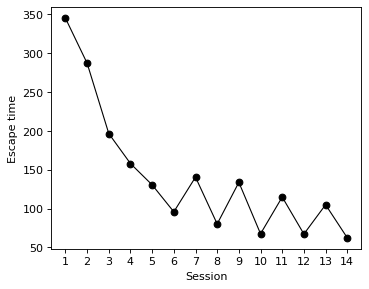

In [10]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby("session").mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["escape time"].plot(color="black", xlabel="Session", ylabel="Escape time", linewidth=1., marker="o")

df4 = df4.groupby("session").mean()
plt.xticks(range(1,15))



In [11]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="first"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     350.7
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           1.41e-56
Time:                        17:27:03   Log-Likelihood:                -2301.3
No. Observations:                 400   AIC:                             4607.
Df Residuals:                     398   BIC:                             4614.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        320.2596      6.397     50.067      0.000     307.684     332.835
session      -64.0337      3.419    -18.728      0.000     -70.756     -57.312
==============================================================================
Omnibus:                        3.233   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.462
Skew:                          -0.018   Prob(JB):                        0.292
Kurtosis:                       2.617   Cond. No.                         3.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# LINEAR REGRESSION ON ESCAPE TIME SECOND STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     69.07
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           3.07e-16
Time:                        17:27:06   Log-Likelihood:                -5322.6
No. Observations:                1000   AIC:                         1.065e+04
Df Residuals:                     998   BIC:                         1.066e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.7742      3.391     32.966      0.000     105.121     118.428
session       -4.5416      0.546     -8.311      0.000      -5.614      -3.469
==============================================================================
Omnibus:                      401.113   Durbin-Watson:                   1.641
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1579.658
Skew:                           1.914   Prob(JB):                         0.00
Kurtosis:                       7.823   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

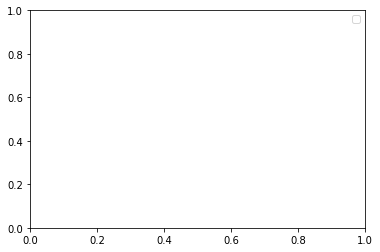

In [10]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

list_of_dataframes = []
for ang in [0,45,90,135,180]:
    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-ang), df3["angle"]==str(ang)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

    df2 = df2.reset_index()
    proximal_posx=df2.proximal_posx.iloc[0]
    proximal_posy=df2.proximal_posy.iloc[0]
    
    df2 = df2.groupby(["time", "agent"]).mean()
    df2 = df2.reset_index()
    df2["proximal_posx"] = float(proximal_posx)
    df2["proximal_posy"] = float(proximal_posy)
    df2["angle"] = abs(int(ang))

    plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

    def is_explo(previous_coord, coord, platform_coord):
        return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])


    
    df2["previous_coord"] = df2["state"]
    df2["has_reached_prox"] = 0
    for i in range(100):
        print(i)
        for t in range(1,250):
            ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
            ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]
            df2.loc[ilo2, "previous_coord"] = df2.loc[ilo1, "state"]

            if df2.loc[ilo2, 'isinoctant_proximal']:
                df2.loc[ilo2, "has_reached_prox"] = 1
            elif df2.loc[ilo1, "has_reached_prox"] == 1 or df2.loc[ilo1, "has_reached_prox"] == 2:
                df2.loc[ilo2, "has_reached_prox"] = 2
    #         if  df2.loc[ilo1, "has_reached_prox"] == 2:
    #             df2.loc[ilo2, "has_reached_prox"] = 2
    list_of_dataframes.append(df2)
df12 = pd.concat(list_of_dataframes)


In [11]:
from scipy.stats import entropy

df12["entro_mf"] = df12.apply(lambda row: entropy(np.array([row.Qprox0+row.Qdist0, row.Qprox1+row.Qdist1, row.Qprox2+row.Qdist2, row.Qprox3+row.Qdist3, row.Qprox4+row.Qdist4, row.Qprox5+row.Qdist5])), axis=1)
df12["var_prox"] = df12.apply(lambda row: np.array([row.Qprox0, row.Qprox1, row.Qprox2, row.Qprox3, row.Qprox4, row.Qprox5]).var(), axis=1)
df12["var_dist"] = df12.apply(lambda row: np.array([row.Qdist0, row.Qdist1, row.Qdist2, row.Qdist3, row.Qdist4, row.Qdist5]).var(), axis=1)
df12["var_sr"] = df12.apply(lambda row: np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5]).var(), axis=1)
df12["var_mf"] = df12.apply(lambda row: np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5]).var(), axis=1)

df7 = df12.groupby("state").mean()

In [12]:
def get_strategies(rew_func_sum, Qcombmf, Qcombsr, Qcombprox, Qcombdist, var_mf, var_sr):

    if Qcombmf and Qcombsr and var_mf>var_sr:
        if Qcombprox and Qcombdist:
            return "MF Both win"
        elif Qcombdist:
            return "MF Distal win"
        elif Qcombprox:
            return "MF Proximal win"

        else:
            return "MF Neither win"
        
    elif Qcombmf and Qcombsr and var_mf<var_sr:
        if rew_func_sum:
            return "SR platform"
        else:
            return "SR exploration"
    
    elif Qcombmf:
        if Qcombprox and Qcombdist:
            return "MF Both win"
        elif Qcombdist:
            return "MF Distal win"
        elif Qcombprox:
            return "MF Proximal win"

        else:
            return "MF Neither win"
        
    else:
        if rew_func_sum:
            return "SR platform"
        else:
            return "SR exploration"
        
    
df12["Strategies"] = df12.apply(lambda row: get_strategies(row.rew_func_sum, row.Qcombmf, row.Qcombsr, row.Qcombprox, row.Qcombdist, row.var_mf, row.var_sr), axis=1)

In [13]:
data2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["has_reached_prox", "Strategies", "angle"]).count()
data2 = data2["time"]/25100


In [14]:
data3=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data3 = data3["time"]/25100


In [15]:
data4=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data4 = data4["time"]/25100

In [16]:
data2 = data2.reset_index()
data2 = data2[data2["has_reached_prox"]==0]
data2 = data2.set_index(["angle", "Strategies"], drop=True).time

In [17]:
data3 = data3.reset_index()
data3 = data3[data3["has_reached_prox"]==1]
data3 = data3.set_index(["angle", "Strategies"], drop=True).time

In [18]:
data4 = data4.reset_index()
data4 = data4[data4["has_reached_prox"]==2]
data4 = data4.set_index(["angle", "Strategies"], drop=True).time

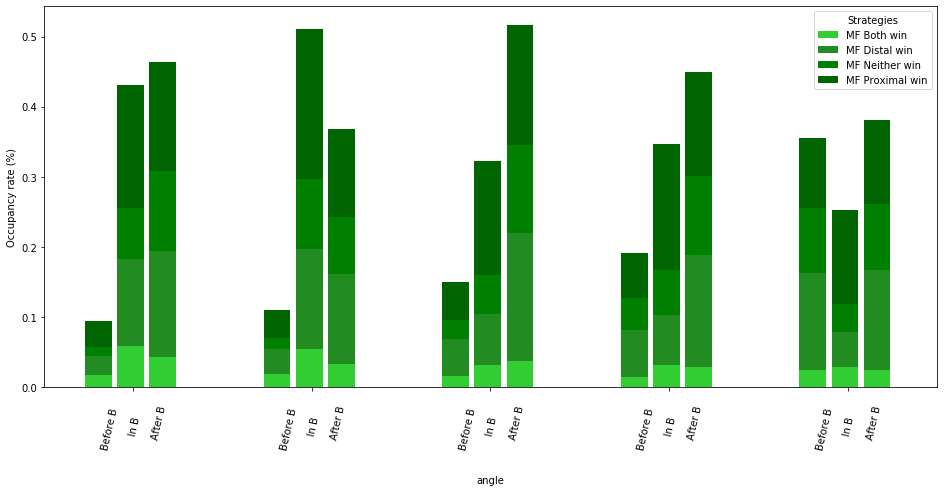

In [24]:
fig, ax = plt.subplots(figsize=(16,7))
#data2["time"].plot(kind='bar', position=1, ax=ax)


data2.unstack().plot(kind='bar', position=1.8, ax=ax, legend=False,stacked=True,width=0.15, color=['limegreen', 'forestgreen','green', "darkgreen","lightseagreen","darkslateblue"])
data3.unstack().plot(kind='bar', position=0.6, ax=ax, legend=False,stacked=True,width=0.15,color=['limegreen', 'forestgreen', 'green',"darkgreen","lightseagreen","darkslateblue"])
data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15, color=['limegreen', 'forestgreen', 'green',"darkgreen","lightseagreen","darkslateblue"])

ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=77)
ax.set_ylabel("Occupancy rate (%)")
plt.xlim((-0.5, len(data4)/4-0.5));

In [19]:
from scipy import stats

df2 = data2.unstack().sum(axis=1)
df2 = df2.reset_index()

df5 = data3.unstack().sum(axis=1)
df5 = df5.reset_index()
stats.pearsonr(df2[0],df5[0])

(-0.8215570917878237, 0.08802430573229139)

In [20]:
from scipy import stats

df2 = data3.unstack().sum(axis=1)
df2 = df2.reset_index()

df5 = data4.unstack().sum(axis=1)
df5 = df5.reset_index()
stats.pearsonr(df2[0],df5[0])

(-0.22345105716860192, 0.7178789218760914)

In [21]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = data2.unstack().sum(axis=1)
df2 = df2.reset_index()


Y = df2[0]
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     14.26
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0325
Time:                        22:05:48   Log-Likelihood:                 9.0945
No. Observations:                   5   AIC:                            -14.19
Df Residuals:                       3   BIC:                            -14.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0589      0.039      1.502      0.230      -0.066       0.184
angle          0.0013      0.000      3.776      0.033       0.000       0.002
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.772
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.523
Skew:                           0.191   Prob(JB):                        0.770
Kurtosis:                       1.462   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = data3.unstack().sum(axis=1)
df2 = df2.reset_index()


Y = df2[0]
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     6.343
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0863
Time:                        22:05:54   Log-Likelihood:                 7.8128
No. Observations:                   5   AIC:                            -11.63
Df Residuals:                       3   BIC:                            -12.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4771      0.051      9.406      0.003       0.316       0.638
angle         -0.0012      0.000     -2.519      0.086      -0.003       0.000
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.364
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.568
Skew:                           0.641   Prob(JB):                        0.753
Kurtosis:                       1.958   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = data4.unstack().sum(axis=1)
df2 = df2.reset_index()


Y = df2[0]
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                 -0.272
Method:                 Least Squares   F-statistic:                    0.1455
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.728
Time:                        22:06:01   Log-Likelihood:                 7.5038
No. Observations:                   5   AIC:                            -11.01
Df Residuals:                       3   BIC:                            -11.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4527      0.054      8.391      0.004       0.281       0.624
angle         -0.0002      0.000     -0.381      0.728      -0.002       0.001
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.723
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.260
Skew:                           0.064   Prob(JB):                        0.878
Kurtosis:                       1.891   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### In function of angle

In [25]:
df12["distwin"]=np.logical_and(np.logical_and(df12["Qcombmf"]==1, df12["Qcombprox"]==0), df12["Qcombdist"]==1)
df12["proxwin"]=np.logical_and(np.logical_and(df12["Qcombmf"]==1, df12["Qcombprox"]==1), df12["Qcombdist"]==0)

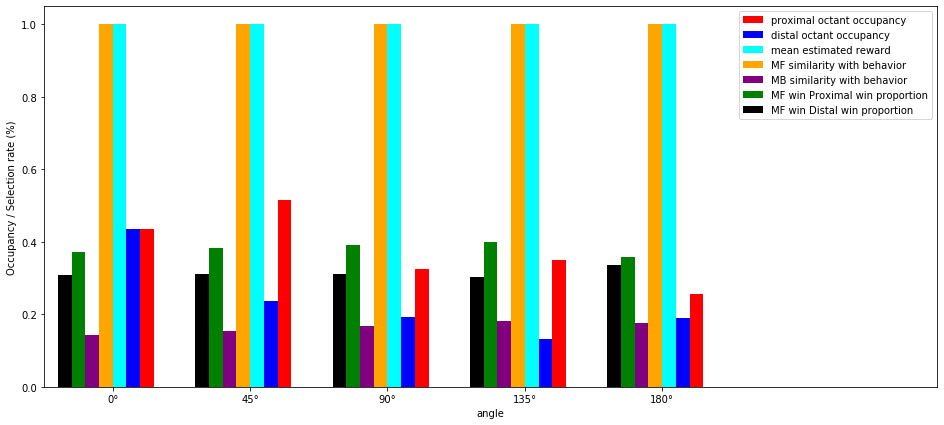

In [26]:
fig, ax = plt.subplots(figsize=(16,7))
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['isinoctant_proximal'].plot(position=-2, kind="bar", width=0.1, color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['isinoctant_distal'].plot(position=-1, kind="bar", width=0.1,color="b")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['rew_func_sum'].plot(position=0, kind="bar", width=0.1,color="cyan")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombmf'].plot(position=1, kind="bar", width=0.1, color="orange")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombsr'].plot(position=2, kind="bar", width=0.1, color="purple")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['proxwin'].plot(position=3, kind="bar", width=0.1, color="green")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['distwin'].plot(position=4, kind="bar", width=0.1, color="black")
#df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombmf'].plot(position=2, kind="bar", width=0.1,color="green")
ax.set_xticklabels(["0°", "45°", "90°", "135°", "180°"], rotation=0)
ax.set_ylabel("Occupancy / Selection rate (%)")
plt.xlim((-0.5, 6.5-0.5));
plt.legend(["proximal octant occupancy", "distal octant occupancy", "mean estimated reward", "MF similarity with behavior", "MB similarity with behavior","MF win Proximal win proportion", "MF win Distal win proportion"])

In [27]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["agent", "angle"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_proximal']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     isinoctant_proximal   R-squared:                       0.166
Model:                             OLS   Adj. R-squared:                  0.164
Method:                  Least Squares   F-statistic:                     98.81
Date:                 Tue, 21 Dec 2021   Prob (F-statistic):           2.33e-21
Time:                         17:54:36   Log-Likelihood:                 184.10
No. Observations:                  500   AIC:                            -364.2
Df Residuals:                      498   BIC:                            -355.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4822      0.013     37.104      0.000       0.457       0.508
angle         -0.0012      0.000     -9.940      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       15.102   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.037
Skew:                           0.435   Prob(JB):                     0.000329
Kurtosis:                       2.885   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_distal']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      isinoctant_distal   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     146.2
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           1.11e-29
Time:                        17:54:41   Log-Likelihood:                 221.10
No. Observations:                 500   AIC:                            -438.2
Df Residuals:                     498   BIC:                            -429.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3568      0.012     29.565      0.000       0.333       0.381
angle         -0.0013      0.000    -12.089      0.000      -0.002      -0.001
==============================================================================
Omnibus:                       35.646   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.263
Skew:                           0.681   Prob(JB):                     1.10e-09
Kurtosis:                       3.352   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[ np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()

df2 = df2.reset_index()


Y = df2['rew_func_sum']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rew_func_sum   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -498.0
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               1.00
Time:                        17:54:45   Log-Likelihood:                 16754.
No. Observations:                 500   AIC:                        -3.350e+04
Df Residuals:                     498   BIC:                        -3.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   5.27e-17    1.9e+16      0.000       1.000       1.000
angle      -1.071e-17   4.78e-19    -22.395      0.000   -1.16e-17   -9.77e-18
==============================================================================
Omnibus:                     1918.404   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.559
Skew:                          -0.049   Prob(JB):                     4.24e-09
Kurtosis:                       1.643   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['Qcombmf']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombmf   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -498.0
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               1.00
Time:                        17:54:50   Log-Likelihood:                 16754.
No. Observations:                 500   AIC:                        -3.350e+04
Df Residuals:                     498   BIC:                        -3.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   5.27e-17    1.9e+16      0.000       1.000       1.000
angle      -1.071e-17   4.78e-19    -22.395      0.000   -1.16e-17   -9.77e-18
==============================================================================
Omnibus:                     1918.404   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.559
Skew:                          -0.049   Prob(JB):                     4.24e-09
Kurtosis:                       1.643   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()

df2 = df2.reset_index()


Y = df2['Qcombsr']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombsr   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     34.64
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           7.30e-09
Time:                        17:54:54   Log-Likelihood:                 773.37
No. Observations:                 500   AIC:                            -1543.
Df Residuals:                     498   BIC:                            -1534.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1451      0.004     36.294      0.000       0.137       0.153
angle          0.0002   3.63e-05      5.885      0.000       0.000       0.000
==============================================================================
Omnibus:                       38.266   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.760
Skew:                           0.671   Prob(JB):                     1.16e-10
Kurtosis:                       3.627   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['distwin']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                distwin   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.596
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0184
Time:                        17:54:59   Log-Likelihood:                 708.74
No. Observations:                 500   AIC:                            -1413.
Df Residuals:                     498   BIC:                            -1405.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3051      0.005     67.037      0.000       0.296       0.314
angle       9.767e-05   4.13e-05      2.366      0.018    1.66e-05       0.000
==============================================================================
Omnibus:                        4.349   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                4.977
Skew:                           0.094   Prob(JB):                       0.0830
Kurtosis:                       3.451   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['proxwin']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                proxwin   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4413
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.507
Time:                        17:55:04   Log-Likelihood:                 668.10
No. Observations:                 500   AIC:                            -1332.
Df Residuals:                     498   BIC:                            -1324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3836      0.005     77.706      0.000       0.374       0.393
angle      -2.975e-05   4.48e-05     -0.664      0.507      -0.000    5.82e-05
==============================================================================
Omnibus:                        1.872   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.728
Skew:                          -0.069   Prob(JB):                        0.421
Kurtosis:                       3.253   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### In function of time

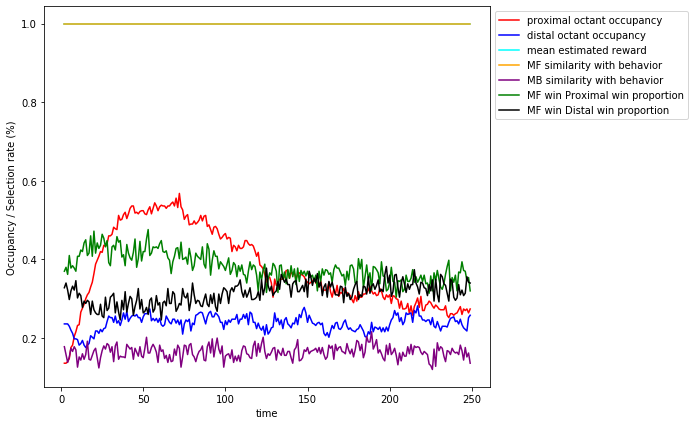

In [35]:
fig, ax = plt.subplots(figsize=(8,7))
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['isinoctant_proximal'].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['isinoctant_distal'].plot(color="b")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['rew_func_sum'].plot(color="cyan")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['Qcombmf'].plot(color="orange")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['Qcombsr'].plot(color="purple")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['proxwin'].plot(color="green")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['distwin'].plot(color="black")

#df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombmf'].plot(position=2, kind="bar", width=0.1,color="green")
#ax.set_xticklabels(["0°", "45°", "90°", "135°", "180°"], rotation=0)
ax.set_ylabel("Occupancy / Selection rate (%)")
#plt.xlim((-0.5, 5.5-0.5));
plt.legend(["proximal octant occupancy", "distal octant occupancy", "mean estimated reward", "MF similarity with behavior", "MB similarity with behavior","MF win Proximal win proportion", "MF win Distal win proportion"], bbox_to_anchor=(1.0, 1.0))

In [38]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_proximal']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     isinoctant_proximal   R-squared:                       0.303
Model:                             OLS   Adj. R-squared:                  0.300
Method:                  Least Squares   F-statistic:                     106.9
Date:                 Tue, 21 Dec 2021   Prob (F-statistic):           4.88e-21
Time:                         17:57:06   Log-Likelihood:                 261.74
No. Observations:                  248   AIC:                            -519.5
Df Residuals:                      246   BIC:                            -512.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4740      0.011     43.742      0.000       0.453       0.495
time          -0.0008    7.5e-05    -10.338      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       90.418   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.130
Skew:                          -1.581   Prob(JB):                     8.98e-62
Kurtosis:                       7.148   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_distal']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      isinoctant_distal   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.327
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0694
Time:                        17:57:11   Log-Likelihood:                 630.06
No. Observations:                 248   AIC:                            -1256.
Df Residuals:                     246   BIC:                            -1249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2338      0.002     95.265      0.000       0.229       0.239
time        3.098e-05    1.7e-05      1.824      0.069   -2.48e-06    6.44e-05
==============================================================================
Omnibus:                        8.638   Durbin-Watson:                   0.471
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.858
Skew:                          -0.463   Prob(JB):                       0.0119
Kurtosis:                       3.015   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[ np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()

df2 = df2.reset_index()


Y = df2['rew_func_sum']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rew_func_sum   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -246.0
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               1.00
Time:                        17:57:16   Log-Likelihood:                 8341.7
No. Observations:                 248   AIC:                        -1.668e+04
Df Residuals:                     246   BIC:                        -1.667e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   7.68e-17    1.3e+16      0.000       1.000       1.000
time        1.247e-18   5.32e-19      2.346      0.020       2e-19    2.29e-18
==============================================================================
Omnibus:                     1989.868   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.734
Skew:                           0.607   Prob(JB):                     5.25e-10
Kurtosis:                       1.368   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['Qcombmf']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombmf   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -246.0
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               1.00
Time:                        17:57:21   Log-Likelihood:                 8341.7
No. Observations:                 248   AIC:                        -1.668e+04
Df Residuals:                     246   BIC:                        -1.667e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   7.68e-17    1.3e+16      0.000       1.000       1.000
time        1.247e-18   5.32e-19      2.346      0.020       2e-19    2.29e-18
==============================================================================
Omnibus:                     1989.868   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.734
Skew:                           0.607   Prob(JB):                     5.25e-10
Kurtosis:                       1.368   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['Qcombsr']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombsr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6878
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.408
Time:                        17:57:26   Log-Likelihood:                 665.92
No. Observations:                 248   AIC:                            -1328.
Df Residuals:                     246   BIC:                            -1321.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1628      0.002     76.672      0.000       0.159       0.167
time        1.219e-05   1.47e-05      0.829      0.408   -1.68e-05    4.11e-05
==============================================================================
Omnibus:                        0.050   Durbin-Watson:                   1.634
Prob(Omnibus):                  0.975   Jarque-Bera (JB):                0.063
Skew:                          -0.032   Prob(JB):                        0.969
Kurtosis:                       2.956   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()

df2 = df2.reset_index()


Y = df2['proxwin']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                proxwin   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     281.9
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           1.14e-42
Time:                        17:57:30   Log-Likelihood:                 569.96
No. Observations:                 248   AIC:                            -1136.
Df Residuals:                     246   BIC:                            -1129.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4265      0.003    136.390      0.000       0.420       0.433
time          -0.0004   2.16e-05    -16.789      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        0.465   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.793   Jarque-Bera (JB):                0.358
Skew:                          -0.092   Prob(JB):                        0.836
Kurtosis:                       3.028   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['distwin']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                distwin   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     118.5
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           8.80e-23
Time:                        17:57:35   Log-Likelihood:                 591.33
No. Observations:                 248   AIC:                            -1179.
Df Residuals:                     246   BIC:                            -1172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2868      0.003     99.951      0.000       0.281       0.292
time           0.0002   1.99e-05     10.885      0.000       0.000       0.000
==============================================================================
Omnibus:                        2.124   Durbin-Watson:                   1.323
Prob(Omnibus):                  0.346   Jarque-Bera (JB):                2.002
Skew:                           0.140   Prob(JB):                        0.367
Kurtosis:                       2.660   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

([<matplotlib.axis.XTick at 0x21d815549c8>,
 <a list of 14 Text xticklabel objects>)

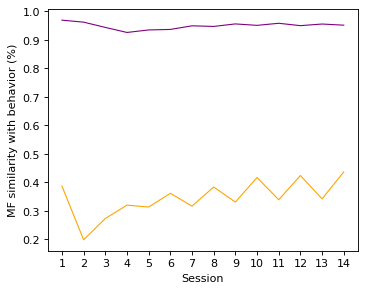

In [46]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby(["session", "agent"]).mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["Qcombsr"].plot(color="orange", xlabel="Session", ylabel="SR similarity with behavior (%)", linewidth=1.)
df4["Qcombmf"].plot(color="purple", xlabel="Session", ylabel="MF similarity with behavior (%)", linewidth=1.)

plt.xticks(range(1,15))



In [47]:
from scipy import stats
#PROXIMAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df4[df4["session"]<7]["Qcombmf"], df4[df4["session"]>=7]["Qcombmf"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=1.4734693877550953, pvalue=0.22479909925003677)


In [48]:
from scipy import stats
#PROXIMAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df4[df4["session"]<7]["Qcombsr"], df4[df4["session"]>=7]["Qcombsr"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=5.0, pvalue=0.025347318677468325)


In [51]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
#df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle"]).mean()

#df4 = df4.reset_index()


Y = df4['Qcombmf']
X = df4[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombmf   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.074
Method:                 Least Squares   F-statistic:                    0.1052
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.751
Time:                        17:58:34   Log-Likelihood:                 43.393
No. Observations:                  14   AIC:                            -82.79
Df Residuals:                      12   BIC:                            -81.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9473      0.006    158.586      0.000       0.934       0.960
session        0.0003      0.001      0.324      0.751      -0.001       0.002
==============================================================================
Omnibus:                        0.432   Durbin-Watson:                   0.742
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.048
Skew:                          -0.134   Prob(JB):                        0.976
Kurtosis:                       2.898   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
#df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle"]).mean()

#df4 = df4.reset_index()


Y = df4['Qcombsr']
X = df4[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombsr   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     7.060
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0209
Time:                        17:58:39   Log-Likelihood:                 22.459
No. Observations:                  14   AIC:                            -40.92
Df Residuals:                      12   BIC:                            -39.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2855      0.027     10.715      0.000       0.227       0.344
session        0.0093      0.003      2.657      0.021       0.002       0.017
==============================================================================
Omnibus:                        0.168   Durbin-Watson:                   2.760
Prob(Omnibus):                  0.919   Jarque-Bera (JB):                0.048
Skew:                           0.051   Prob(JB):                        0.976
Kurtosis:                       2.731   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Evolution of MF weights

In [53]:
df12["distance_prox"] = df12.apply(lambda row: calculateDistance((row.proximal_posx, row.proximal_posy), coords[row.state]), axis=1)
df12["distance_dist"] = df12.apply(lambda row: calculateDistance(coords[90], coords[row.state]), axis=1)
df12["distance_prox"] = df12["distance_prox"].astype(int)
df12["distance_dist"] = df12["distance_dist"].astype(int)

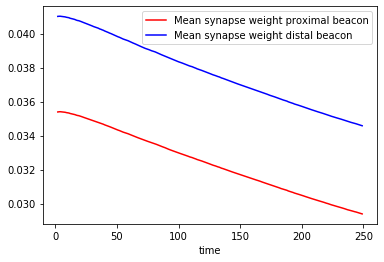

In [54]:
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_prox_mean"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_dist_mean"].plot(color="b")
plt.legend(["Mean synapse weight proximal beacon", "Mean synapse weight distal beacon"],  bbox_to_anchor=(1.0, 1.0))

In [55]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("agent").mean()["syn_dist_mean"], df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("agent").mean()["syn_prox_mean"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=149.25373134328356, pvalue=2.523939423990366e-34)


Evolution of DIST/PROX selection rate and variance

Text(0, 0.5, 'Selection rate (%)')

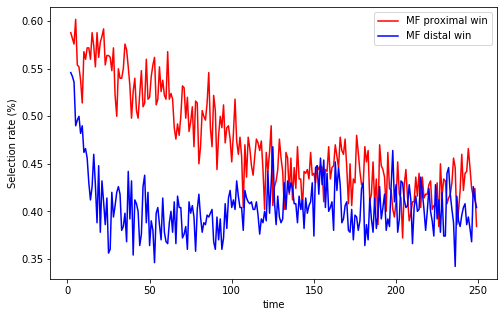

In [56]:
fig, ax = plt.subplots(figsize=(8,5))
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["Qcombprox"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["Qcombdist"].plot(color="b")
plt.legend(["MF proximal win", "MF distal win"],  bbox_to_anchor=(1.0, 1.0))
ax.set_ylabel("Selection rate (%)")

In [58]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>50, df12["time"]<250)].groupby("agent").mean()["Qcombprox"], df12[np.logical_and(df12["time"]>50, df12["time"]<250)].groupby("agent").mean()["Qcombdist"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=80.11943159262384, pvalue=3.5244924774280797e-19)


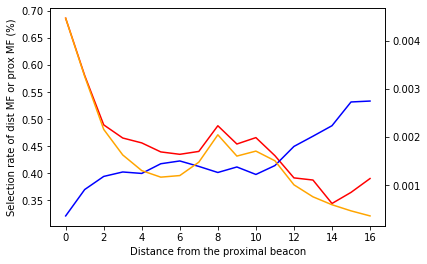

In [59]:
fig, ax = plt.subplots(1, 1)
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()["Qcombprox"].plot(ax=ax, color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()["Qcombdist"].plot(ax=ax, color="b")
#plt.legend(["proximal octant", "distal octant", "mean reward", "SR win", "MF win"],  bbox_to_anchor=(1.0, 1.0))
ax2 = ax.twinx()
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()["var_prox"].plot(ax=ax2,color="orange")

ax.set_ylabel("Selection rate of dist MF or prox MF (%)")
ax.set_xlabel("Distance from the proximal beacon")
#plt.legend(["proximal octant", "distal octant", "mean reward", "SR win", "MF win"],  bbox_to_anchor=(1.0, 1.0))

plt.draw()

In [60]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df14 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()
df14=df14.reset_index()

Y = df14["Qcombprox"]
X = df14["distance_prox"]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Qcombprox   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     28.88
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           7.73e-05
Time:                        17:59:14   Log-Likelihood:                 28.170
No. Observations:                  17   AIC:                            -52.34
Df Residuals:                      15   BIC:                            -50.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5582      0.023     24.469      0.000       0.510       0.607
distance_prox    -0.0131      0.002     -5.374      0.000      -0.018      -0.008
==============================================================================
Omnibus:                        6.221   Durbin-Watson:                   0.682
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                3.465
Skew:                           0.994   Prob(JB):                        0.177
Kurtosis:                       3.969   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df14 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()
df14=df14.reset_index()

Y = df14["Qcombdist"]
X = df14["distance_prox"]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Qcombdist   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     51.02
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           3.38e-06
Time:                        17:59:21   Log-Likelihood:                 38.530
No. Observations:                  17   AIC:                            -73.06
Df Residuals:                      15   BIC:                            -71.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3503      0.012     28.241      0.000       0.324       0.377
distance_prox     0.0094      0.001      7.143      0.000       0.007       0.012
==============================================================================
Omnibus:                        1.544   Durbin-Watson:                   0.512
Prob(Omnibus):                  0.462   Jarque-Bera (JB):                1.017
Skew:                          -0.290   Prob(JB):                        0.601
Kurtosis:                       1.952   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df14 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()
df14=df14.reset_index()
df14["var_prox"] = df14["var_prox"]*200

Y = df14["var_prox"]
X = df14["distance_prox"]

X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               var_prox   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     24.26
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           0.000183
Time:                        17:59:26   Log-Likelihood:                 11.509
No. Observations:                  17   AIC:                            -19.02
Df Residuals:                      15   BIC:                            -17.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5691      0.061      9.361      0.000       0.440       0.699
distance_prox    -0.0319      0.006     -4.925      0.000      -0.046      -0.018
==============================================================================
Omnibus:                        3.350   Durbin-Watson:                   0.495
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                1.416
Skew:                           0.622   Prob(JB):                        0.493
Kurtosis:                       3.671   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Variance')

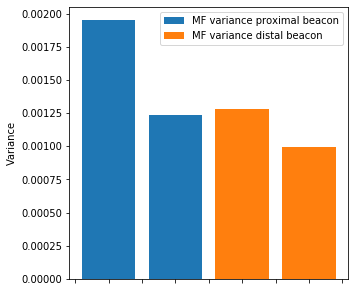

In [63]:

fig, ax = plt.subplots(figsize=(5,5))
plt.bar(x=[1,2], height=[df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby("state").mean()["var_prox"].mean(),df12[np.logical_and(df12["time"]>125, df12["time"]<250)].groupby("state").mean()["var_prox"].mean()])

plt.bar(x=[3,4], height=[df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby("state").mean()["var_dist"].mean(),df12[np.logical_and(df12["time"]>125, df12["time"]<250)].groupby("state").mean()["var_dist"].mean()])
#ax.legend(labels=['Proximal MF'], bbox_to_anchor=(1., 1.2))
plt.legend(["MF variance proximal beacon", "MF variance distal beacon"],  bbox_to_anchor=(1.0, 1.0))
ax.set_xticklabels(["", "", "", ""], rotation=70)
ax.set_ylabel("Variance")

In [64]:
from scipy import stats
#PROXIMAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_prox"], df12[np.logical_and(df12["time"]>1, df12["time"]>125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_prox"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=136.7510208955224, pvalue=1.3669359019908538e-31)


In [65]:
from scipy import stats
# DISTAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_dist"], df12[np.logical_and(df12["time"]>1, df12["time"]>125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_dist"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=96.91248358208952, pvalue=7.24603762410691e-23)


#### MF Variance NEAR DISTAL/PROXIMAL

In [66]:
from scipy.stats import entropy
df12["var_prox"] = df12.apply(lambda row: np.array([row.Qprox0, row.Qprox1, row.Qprox2, row.Qprox3, row.Qprox4, row.Qprox5]).var(), axis=1)
df12["var_dist"] = df12.apply(lambda row: np.array([row.Qdist0, row.Qdist1, row.Qdist2, row.Qdist3, row.Qdist4, row.Qdist5]).var(), axis=1)


In [67]:
df12["distance1"] = df12.apply(lambda row: calculateDistance(coords[75], coords[row.state]), axis=1)
df12["distance_group1"] = df12.apply(lambda row: row.distance1 > 3, axis=1)
df12["distance_group1"]=df12['distance_group1'].replace([True, False], ["d>30cm", 'd<30cm'])

In [68]:
df3=df12
df7 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby("state").mean()
df8 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby(["state", "distance_group1"]).mean()

In [69]:
# number of state where variance SR > variance MF
df7["ratio_prox_dist"] = df7["var_prox"]/df7["var_dist"]
df7[df7["ratio_prox_dist"] < 1]["ratio_prox_dist"].count()
df8["ratio_prox_dist"] = df8["var_prox"]/df8["var_dist"]
df8[df8["ratio_prox_dist"] < 1]["ratio_prox_dist"].count()

161

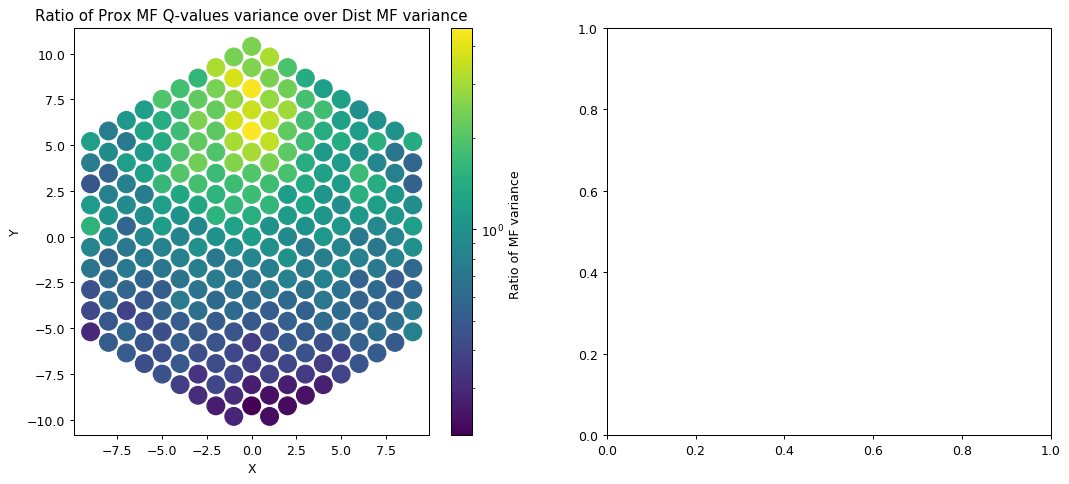

In [70]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["var_prox"][cpt]/df7["var_dist"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z, norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Ratio of Prox MF Q-values variance over Dist MF variance")
plt.colorbar(im, label="Ratio of MF variance ",ax = axs[0])


In [71]:
from scipy import stats
df8=df8.reset_index()
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df8[df8["distance_group1"]=="d>30cm"]["ratio_prox_dist"], df8[df8["distance_group1"]=="d<30cm"]["ratio_prox_dist"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=48.151592215833716, pvalue=3.945084722864033e-12)


#### MF ENTROPY NEAR DISTAL/PROXIMAL

In [72]:
df12["distance2"] = df12.apply(lambda row: calculateDistance(coords[75], coords[row.state]), axis=1)
df12["distance_group2"] = df12.apply(lambda row: row.distance2 > 3, axis=1)
df12["distance_group2"]=df12['distance_group2'].replace([True, False], ["d>30cm", 'd<30cm'])

In [73]:
df3=df12
df7 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby("state").mean()
df8 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby(["state", "distance_group2"]).mean()

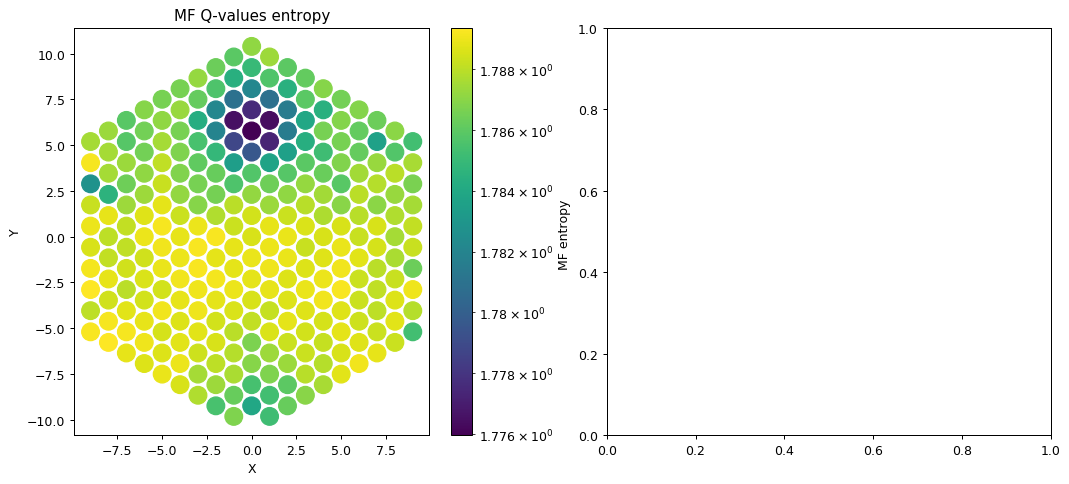

In [74]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["entro_mf"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z, norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values entropy")
plt.colorbar(im, label="MF entropy ",ax = axs[0])


In [75]:
from scipy import stats
df8=df8.reset_index()
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df8[df8["distance_group2"]=="d>30cm"]["entro_mf"], df8[df8["distance_group2"]=="d<30cm"]["entro_mf"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=51.18908484446422, pvalue=8.388375926277123e-13)


## Rodrigo - HPC Lesioned model - No learning

In [7]:
env_params = EnvironmentParams()
env_params.maze_size = 10
env_params.n_agents = 100
env_params.init_sr = "zero"
env_params.landmark_dist = 0
env_params.time_limit = 500
env_params.starting_states = [243,230,270,257]

ag_params = AgentsParams()
ag_params.mf_allo = False
ag_params.hpc_lr = 0.069
ag_params.q_lr = 0.1467
ag_params.inv_temp = 13
ag_params.gamma = 0.853
ag_params.eta = 0.03 # reliability learning rate
ag_params.alpha1 = 0.01
ag_params.beta1 = 0.1
ag_params.A_alpha = 3.2 # Steepness of transition curve MF to SR
ag_params.A_beta = 1.1 # Steepness of transition curve SR to MF
ag_params.HPCmode = "SR"
ag_params.lesion_HPC = False
ag_params.lesion_DLS = False
ag_params.dolle = False

In [8]:
from utils import get_coords
coords = get_coords()

In [9]:
from rodrigo_protocol import create_path_rodrigo
path = create_path_rodrigo(env_params, ag_params)

In [10]:
df = create_df(path, 100)

([<matplotlib.axis.XTick at 0x21d80024c88>,
 <a list of 14 Text xticklabel objects>)

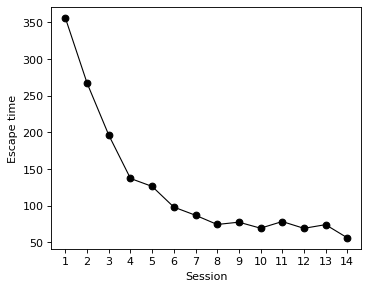

In [80]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby("session").mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["escape time"].plot(color="black", xlabel="Session", ylabel="Escape time", linewidth=1., marker="o")

df4 = df4.groupby("session").mean()
plt.xticks(range(1,15))



In [81]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="first"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     490.7
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           2.00e-71
Time:                        18:06:31   Log-Likelihood:                -2275.9
No. Observations:                 400   AIC:                             4556.
Df Residuals:                     398   BIC:                             4564.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        325.5148      6.003     54.222      0.000     313.713     337.317
session      -71.0861      3.209    -22.153      0.000     -77.395     -64.778
==============================================================================
Omnibus:                        2.258   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                2.085
Skew:                          -0.173   Prob(JB):                        0.353
Kurtosis:                       3.070   Cond. No.                         3.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
# LINEAR REGRESSION ON ESCAPE TIME SECOND STAGE

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]
df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby(["session", "agent"]).mean()
df2 = df2.reset_index()


Y = df2["escape time"]
X = df2[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            escape time   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     129.1
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           3.14e-28
Time:                        18:06:34   Log-Likelihood:                -4944.9
No. Observations:                1000   AIC:                             9894.
Df Residuals:                     998   BIC:                             9904.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.1844      2.324     40.957      0.000      90.624      99.745
session       -4.2564      0.375    -11.364      0.000      -4.991      -3.521
==============================================================================
Omnibus:                      644.071   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10868.533
Skew:                           2.675   Prob(JB):                         0.00
Kurtosis:                      18.239   Cond. No.                         13.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

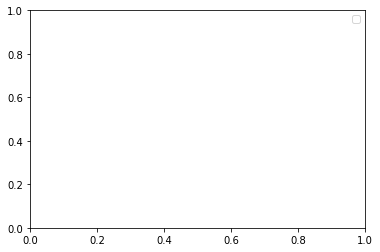

In [11]:
from utils import isinoctant
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import pyplot as plt

list_of_dataframes = []
for ang in [0,45,90,135,180]:
    df3 = df.reset_index()
    df2 = df3[np.logical_and(np.logical_or(df3["angle"]==str(-ang), df3["angle"]==str(ang)), df3["agent"]>=0)]
    #df2["time"] = pd.cut(df2['time'], 10)
    df2['isinoctant_distal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.distal_posx), float(row.distal_posy)])), axis=1)
    df2['isinoctant_proximal'] = df2.apply(lambda row: int(isinoctant(coords[row.state], [float(row.proximal_posx), float(row.proximal_posy)])), axis=1)

    df2 = df2.reset_index()
    proximal_posx=df2.proximal_posx.iloc[0]
    proximal_posy=df2.proximal_posy.iloc[0]
    
    df2 = df2.groupby(["time", "agent"]).mean()
    df2 = df2.reset_index()
    df2["proximal_posx"] = float(proximal_posx)
    df2["proximal_posy"] = float(proximal_posy)
    df2["angle"] = abs(int(ang))

    plt.legend(["prox_octant", "dist_octant", "mean_reward", "similarity_SR-behavior", "similarity_MF-behavior"], bbox_to_anchor=(1.0, 1.0))

    def is_explo(previous_coord, coord, platform_coord):
        return calculateDistance(coords[previous_coord], coords[platform_coord]) < calculateDistance(coords[coord], coords[platform_coord])


    
    df2["previous_coord"] = df2["state"]
    df2["has_reached_prox"] = 0
    for i in range(100):
        print(i)
        for t in range(1,250):
            ilo1 = df2.index[np.logical_and(df2["time"]==t-1, df2["agent"]==i)][0]
            ilo2 = df2.index[np.logical_and(df2["time"]==t, df2["agent"]==i)][0]
            df2.loc[ilo2, "previous_coord"] = df2.loc[ilo1, "state"]

            if df2.loc[ilo2, 'isinoctant_proximal']:
                df2.loc[ilo2, "has_reached_prox"] = 1
            elif df2.loc[ilo1, "has_reached_prox"] == 1 or df2.loc[ilo1, "has_reached_prox"] == 2:
                df2.loc[ilo2, "has_reached_prox"] = 2
    #         if  df2.loc[ilo1, "has_reached_prox"] == 2:
    #             df2.loc[ilo2, "has_reached_prox"] = 2
    list_of_dataframes.append(df2)
df12 = pd.concat(list_of_dataframes)


In [12]:
from scipy.stats import entropy

df12["entro_mf"] = df12.apply(lambda row: entropy(np.array([row.Qprox0+row.Qdist0, row.Qprox1+row.Qdist1, row.Qprox2+row.Qdist2, row.Qprox3+row.Qdist3, row.Qprox4+row.Qdist4, row.Qprox5+row.Qdist5])), axis=1)
df12["var_prox"] = df12.apply(lambda row: np.array([row.Qprox0, row.Qprox1, row.Qprox2, row.Qprox3, row.Qprox4, row.Qprox5]).var(), axis=1)
df12["var_dist"] = df12.apply(lambda row: np.array([row.Qdist0, row.Qdist1, row.Qdist2, row.Qdist3, row.Qdist4, row.Qdist5]).var(), axis=1)
df12["var_sr"] = df12.apply(lambda row: np.array([row.Qsr0, row.Qsr1, row.Qsr2, row.Qsr3, row.Qsr4, row.Qsr5]).var(), axis=1)
df12["var_mf"] = df12.apply(lambda row: np.array([row.Qmf0, row.Qmf1, row.Qmf2, row.Qmf3, row.Qmf4, row.Qmf5]).var(), axis=1)

df7 = df12.groupby("state").mean()

In [13]:
def get_strategies(rew_func_sum, Qcombmf, Qcombsr, Qcombprox, Qcombdist, var_mf, var_sr):

    if Qcombmf and Qcombsr and var_mf>var_sr:
        if Qcombprox and Qcombdist:
            return "MF Both win"
        elif Qcombdist:
            return "MF Distal win"
        elif Qcombprox:
            return "MF Proximal win"

        else:
            return "MF Neither win"
        
    elif Qcombmf and Qcombsr and var_mf<var_sr:
        if rew_func_sum:
            return "SR platform"
        else:
            return "SR exploration"
    
    elif Qcombmf:
        if Qcombprox and Qcombdist:
            return "MF Both win"
        elif Qcombdist:
            return "MF Distal win"
        elif Qcombprox:
            return "MF Proximal win"

        else:
            return "MF Neither win"
        
    else:
        if rew_func_sum:
            return "SR platform"
        else:
            return "SR exploration"
        
    
df12["Strategies"] = df12.apply(lambda row: get_strategies(row.rew_func_sum, row.Qcombmf, row.Qcombsr, row.Qcombprox, row.Qcombdist, row.var_mf, row.var_sr), axis=1)

In [14]:
data2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["has_reached_prox", "Strategies", "angle"]).count()
data2 = data2["time"]/25100


In [15]:
data3=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data3 = data3["time"]/25100


In [16]:
data4=df12.groupby(["has_reached_prox", "Strategies", "angle"]).count()
data4 = data4["time"]/25100

In [17]:
data2 = data2.reset_index()
data2 = data2[data2["has_reached_prox"]==0]
data2 = data2.set_index(["angle", "Strategies"], drop=True).time

In [18]:
data3 = data3.reset_index()
data3 = data3[data3["has_reached_prox"]==1]
data3 = data3.set_index(["angle", "Strategies"], drop=True).time

In [19]:
data4 = data4.reset_index()
data4 = data4[data4["has_reached_prox"]==2]
data4 = data4.set_index(["angle", "Strategies"], drop=True).time

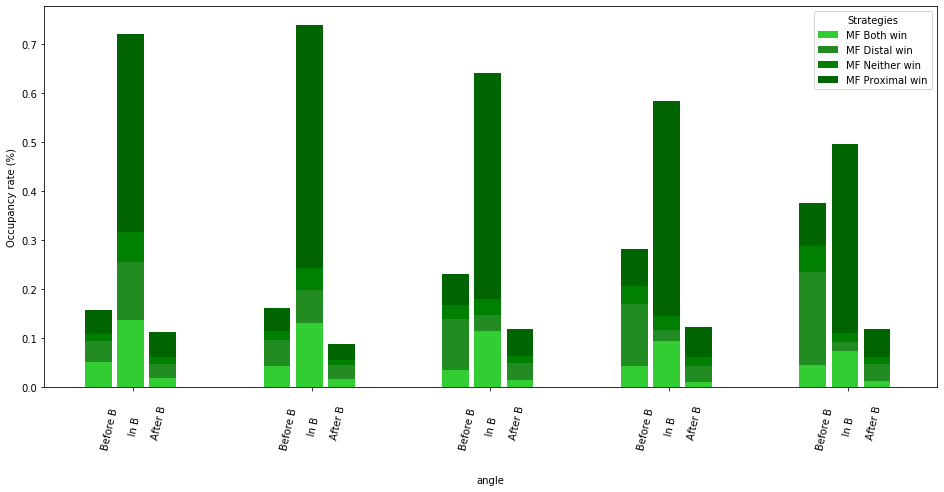

In [92]:
fig, ax = plt.subplots(figsize=(16,7))
#data2["time"].plot(kind='bar', position=1, ax=ax)


data2.unstack().plot(kind='bar', position=1.8, ax=ax, legend=False,stacked=True,width=0.15, color=['limegreen', 'forestgreen','green', "darkgreen","lightseagreen","darkslateblue"])
data3.unstack().plot(kind='bar', position=0.6, ax=ax, legend=False,stacked=True,width=0.15,color=['limegreen', 'forestgreen', 'green',"darkgreen","lightseagreen","darkslateblue"])
data4.unstack().plot(kind='bar', position=-0.6, ax=ax, stacked=True,width=0.15, color=['limegreen', 'forestgreen', 'green',"darkgreen","lightseagreen","darkslateblue"])

ax.set_xticklabels(['Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B', 'Before B \n\n     In B \n\n          After B'], rotation=77)
ax.set_ylabel("Occupancy rate (%)")
plt.xlim((-0.5, len(data4)/4-0.5));

In [20]:
from scipy import stats

df2 = data2.unstack().sum(axis=1)
df2 = df2.reset_index()

df5 = data3.unstack().sum(axis=1)
df5 = df5.reset_index()
stats.pearsonr(df2[0],df5[0])

(-0.9941405110579536, 0.0005379493491422259)

In [21]:
from scipy import stats

df2 = data3.unstack().sum(axis=1)
df2 = df2.reset_index()

df5 = data4.unstack().sum(axis=1)
df5 = df5.reset_index()
stats.pearsonr(df2[0],df5[0])

(-0.7199383480689029, 0.17024374938128473)

In [22]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = data2.unstack().sum(axis=1)
df2 = df2.reset_index()


Y = df2[0]
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     42.61
Date:                Tue, 21 Dec 2021   Prob (F-statistic):            0.00731
Time:                        22:20:51   Log-Likelihood:                 12.263
No. Observations:                   5   AIC:                            -20.53
Df Residuals:                       3   BIC:                            -21.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1304      0.021      6.261      0.008       0.064       0.197
angle          0.0012      0.000      6.527      0.007       0.001       0.002
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.938
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.681
Skew:                           0.291   Prob(JB):                        0.711
Kurtosis:                       1.288   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = data3.unstack().sum(axis=1)
df2 = df2.reset_index()


Y = df2[0]
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     29.82
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0121
Time:                        22:20:57   Log-Likelihood:                 10.938
No. Observations:                   5   AIC:                            -17.88
Df Residuals:                       3   BIC:                            -18.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7566      0.027     27.875      0.000       0.670       0.843
angle         -0.0013      0.000     -5.460      0.012      -0.002      -0.001
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.346
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.251
Skew:                           0.242   Prob(JB):                        0.882
Kurtosis:                       2.014   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = data4.unstack().sum(axis=1)
df2 = df2.reset_index()


Y = df2[0]
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     1.377
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.325
Time:                        22:21:03   Log-Likelihood:                 15.642
No. Observations:                   5   AIC:                            -27.28
Df Residuals:                       3   BIC:                            -28.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1014      0.011      9.568      0.002       0.068       0.135
angle          0.0001   9.61e-05      1.173      0.325      -0.000       0.000
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.877
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.892
Skew:                          -1.000   Prob(JB):                        0.640
Kurtosis:                       2.467   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### In function of angle

In [93]:
df12["distwin"]=np.logical_and(np.logical_and(df12["Qcombmf"]==1, df12["Qcombprox"]==0), df12["Qcombdist"]==1)
df12["proxwin"]=np.logical_and(np.logical_and(df12["Qcombmf"]==1, df12["Qcombprox"]==1), df12["Qcombdist"]==0)

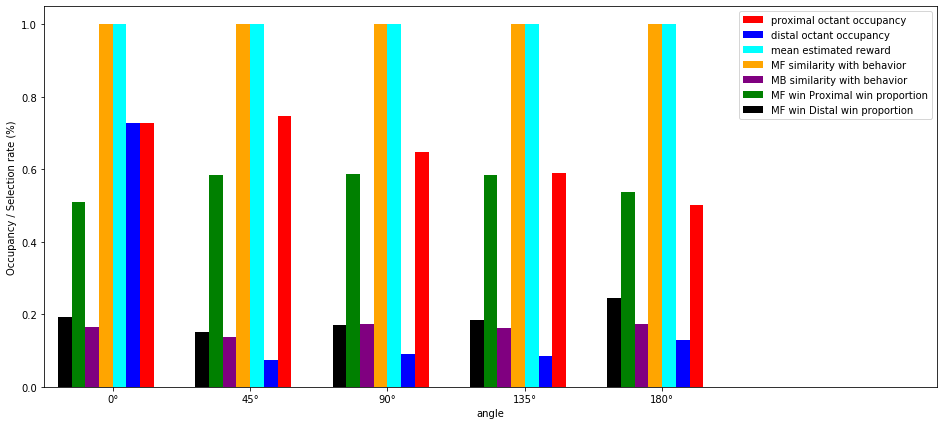

In [94]:
fig, ax = plt.subplots(figsize=(16,7))
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['isinoctant_proximal'].plot(position=-2, kind="bar", width=0.1, color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['isinoctant_distal'].plot(position=-1, kind="bar", width=0.1,color="b")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['rew_func_sum'].plot(position=0, kind="bar", width=0.1,color="cyan")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombmf'].plot(position=1, kind="bar", width=0.1, color="orange")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombsr'].plot(position=2, kind="bar", width=0.1, color="purple")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['proxwin'].plot(position=3, kind="bar", width=0.1, color="green")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['distwin'].plot(position=4, kind="bar", width=0.1, color="black")
#df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombmf'].plot(position=2, kind="bar", width=0.1,color="green")
ax.set_xticklabels(["0°", "45°", "90°", "135°", "180°"], rotation=0)
ax.set_ylabel("Occupancy / Selection rate (%)")
plt.xlim((-0.5, 6.5-0.5));
plt.legend(["proximal octant occupancy", "distal octant occupancy", "mean estimated reward", "MF similarity with behavior", "MB similarity with behavior","MF win Proximal win proportion", "MF win Distal win proportion"])

In [95]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["agent", "angle"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_proximal']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     isinoctant_proximal   R-squared:                       0.091
Model:                             OLS   Adj. R-squared:                  0.089
Method:                  Least Squares   F-statistic:                     49.87
Date:                 Tue, 21 Dec 2021   Prob (F-statistic):           5.56e-12
Time:                         18:38:13   Log-Likelihood:                -62.134
No. Observations:                  500   AIC:                             128.3
Df Residuals:                      498   BIC:                             136.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7654      0.021     35.993      0.000       0.724       0.807
angle         -0.0014      0.000     -7.062      0.000      -0.002      -0.001
==============================================================================
Omnibus:                       39.132   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.948
Skew:                          -0.728   Prob(JB):                     1.05e-10
Kurtosis:                       2.710   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_distal']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      isinoctant_distal   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     239.3
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           2.28e-44
Time:                        18:38:17   Log-Likelihood:                -1.0225
No. Observations:                 500   AIC:                             6.045
Df Residuals:                     498   BIC:                             14.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4595      0.019     24.416      0.000       0.423       0.496
angle         -0.0026      0.000    -15.470      0.000      -0.003      -0.002
==============================================================================
Omnibus:                       44.236   Durbin-Watson:                   0.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.011
Skew:                           0.512   Prob(JB):                     1.12e-07
Kurtosis:                       2.301   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[ np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()

df2 = df2.reset_index()


Y = df2['rew_func_sum']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rew_func_sum   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -498.0
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               1.00
Time:                        18:38:21   Log-Likelihood:                 16754.
No. Observations:                 500   AIC:                        -3.350e+04
Df Residuals:                     498   BIC:                        -3.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   5.27e-17    1.9e+16      0.000       1.000       1.000
angle      -1.071e-17   4.78e-19    -22.395      0.000   -1.16e-17   -9.77e-18
==============================================================================
Omnibus:                     1918.404   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.559
Skew:                          -0.049   Prob(JB):                     4.24e-09
Kurtosis:                       1.643   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['Qcombmf']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombmf   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -498.0
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               1.00
Time:                        18:38:24   Log-Likelihood:                 16754.
No. Observations:                 500   AIC:                        -3.350e+04
Df Residuals:                     498   BIC:                        -3.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   5.27e-17    1.9e+16      0.000       1.000       1.000
angle      -1.071e-17   4.78e-19    -22.395      0.000   -1.16e-17   -9.77e-18
==============================================================================
Omnibus:                     1918.404   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.559
Skew:                          -0.049   Prob(JB):                     4.24e-09
Kurtosis:                       1.643   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()

df2 = df2.reset_index()


Y = df2['Qcombsr']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombsr   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.382
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0368
Time:                        18:38:28   Log-Likelihood:                 740.59
No. Observations:                 500   AIC:                            -1477.
Df Residuals:                     498   BIC:                            -1469.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1551      0.004     36.319      0.000       0.147       0.163
angle       8.109e-05   3.87e-05      2.093      0.037    4.98e-06       0.000
==============================================================================
Omnibus:                        3.496   Durbin-Watson:                   1.719
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                3.294
Skew:                           0.191   Prob(JB):                        0.193
Kurtosis:                       3.113   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['distwin']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                distwin   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     7.804
Date:                Tue, 21 Dec 2021   Prob (F-statistic):            0.00541
Time:                        18:38:31   Log-Likelihood:                 211.61
No. Observations:                 500   AIC:                            -419.2
Df Residuals:                     498   BIC:                            -410.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1615      0.012     13.127      0.000       0.137       0.186
angle          0.0003      0.000      2.794      0.005    9.25e-05       0.001
==============================================================================
Omnibus:                       84.724   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.038
Skew:                           1.119   Prob(JB):                     2.59e-28
Kurtosis:                       4.045   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle", "agent"]).mean()
df2 = df2.reset_index()


Y = df2['proxwin']
X = df2[["angle"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                proxwin   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7966
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.373
Time:                        18:38:35   Log-Likelihood:                 140.64
No. Observations:                 500   AIC:                            -277.3
Df Residuals:                     498   BIC:                            -268.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5503      0.014     38.816      0.000       0.522       0.578
angle          0.0001      0.000      0.893      0.373      -0.000       0.000
==============================================================================
Omnibus:                       23.795   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.297
Skew:                          -0.562   Prob(JB):                     1.95e-06
Kurtosis:                       3.015   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### In function of time

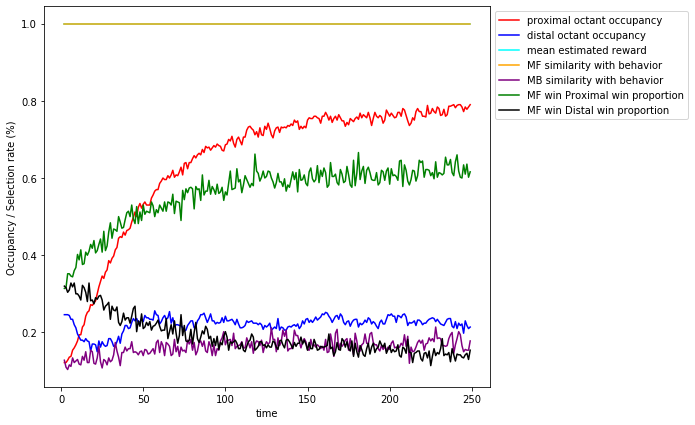

In [102]:
fig, ax = plt.subplots(figsize=(8,7))
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['isinoctant_proximal'].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['isinoctant_distal'].plot(color="b")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['rew_func_sum'].plot(color="cyan")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['Qcombmf'].plot(color="orange")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['Qcombsr'].plot(color="purple")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['proxwin'].plot(color="green")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()['distwin'].plot(color="black")

#df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("angle").mean()['Qcombmf'].plot(position=2, kind="bar", width=0.1,color="green")
#ax.set_xticklabels(["0°", "45°", "90°", "135°", "180°"], rotation=0)
ax.set_ylabel("Occupancy / Selection rate (%)")
#plt.xlim((-0.5, 5.5-0.5));
plt.legend(["proximal octant occupancy", "distal octant occupancy", "mean estimated reward", "MF similarity with behavior", "MB similarity with behavior","MF win Proximal win proportion", "MF win Distal win proportion"], bbox_to_anchor=(1.0, 1.0))

In [103]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_proximal']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     isinoctant_proximal   R-squared:                       0.715
Model:                             OLS   Adj. R-squared:                  0.714
Method:                  Least Squares   F-statistic:                     617.8
Date:                 Tue, 21 Dec 2021   Prob (F-statistic):           4.84e-69
Time:                         18:38:48   Log-Likelihood:                 240.29
No. Observations:                  248   AIC:                            -476.6
Df Residuals:                      246   BIC:                            -469.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3877      0.012     32.813      0.000       0.364       0.411
time           0.0020   8.18e-05     24.856      0.000       0.002       0.002
==============================================================================
Omnibus:                       31.446   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.485
Skew:                          -0.955   Prob(JB):                     2.67e-09
Kurtosis:                       3.413   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['isinoctant_distal']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      isinoctant_distal   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     45.02
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           1.33e-10
Time:                        18:38:53   Log-Likelihood:                 635.17
No. Observations:                 248   AIC:                            -1266.
Df Residuals:                     246   BIC:                            -1259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2078      0.002     86.421      0.000       0.203       0.212
time           0.0001   1.66e-05      6.710      0.000    7.89e-05       0.000
==============================================================================
Omnibus:                       15.157   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.261
Skew:                          -0.570   Prob(JB):                     0.000294
Kurtosis:                       3.523   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[ np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()

df2 = df2.reset_index()


Y = df2['rew_func_sum']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           rew_func_sum   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -246.0
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               1.00
Time:                        18:38:56   Log-Likelihood:                 8341.7
No. Observations:                 248   AIC:                        -1.668e+04
Df Residuals:                     246   BIC:                        -1.667e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   7.68e-17    1.3e+16      0.000       1.000       1.000
time        1.247e-18   5.32e-19      2.346      0.020       2e-19    2.29e-18
==============================================================================
Omnibus:                     1989.868   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.734
Skew:                           0.607   Prob(JB):                     5.25e-10
Kurtosis:                       1.368   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['Qcombmf']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombmf   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -246.0
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               1.00
Time:                        18:39:00   Log-Likelihood:                 8341.7
No. Observations:                 248   AIC:                        -1.668e+04
Df Residuals:                     246   BIC:                        -1.667e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   7.68e-17    1.3e+16      0.000       1.000       1.000
time        1.247e-18   5.32e-19      2.346      0.020       2e-19    2.29e-18
==============================================================================
Omnibus:                     1989.868   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.734
Skew:                           0.607   Prob(JB):                     5.25e-10
Kurtosis:                       1.368   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['Qcombsr']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombsr   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     105.2
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           8.78e-21
Time:                        18:39:04   Log-Likelihood:                 647.35
No. Observations:                 248   AIC:                            -1291.
Df Residuals:                     246   BIC:                            -1284.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1420      0.002     62.036      0.000       0.137       0.147
time           0.0002   1.58e-05     10.257      0.000       0.000       0.000
==============================================================================
Omnibus:                        0.553   Durbin-Watson:                   1.287
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.650
Skew:                           0.105   Prob(JB):                        0.723
Kurtosis:                       2.864   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()

df2 = df2.reset_index()


Y = df2['proxwin']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                proxwin   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     562.7
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           1.63e-65
Time:                        18:39:08   Log-Likelihood:                 442.34
No. Observations:                 248   AIC:                            -880.7
Df Residuals:                     246   BIC:                            -873.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4528      0.005     86.549      0.000       0.442       0.463
time           0.0009   3.62e-05     23.721      0.000       0.001       0.001
==============================================================================
Omnibus:                       20.463   Durbin-Watson:                   0.449
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.331
Skew:                          -0.675   Prob(JB):                     8.58e-06
Kurtosis:                       3.659   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
df2=df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["time"]).mean()
df2 = df2.reset_index()


Y = df2['distwin']
X = df2[["time"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                distwin   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     686.3
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           4.01e-73
Time:                        18:39:11   Log-Likelihood:                 561.16
No. Observations:                 248   AIC:                            -1118.
Df Residuals:                     246   BIC:                            -1111.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2633      0.003     81.248      0.000       0.257       0.270
time          -0.0006   2.24e-05    -26.197      0.000      -0.001      -0.001
==============================================================================
Omnibus:                        7.442   Durbin-Watson:                   0.602
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.574
Skew:                           0.428   Prob(JB):                       0.0227
Kurtosis:                       2.986   Cond. No.                         292.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

([<matplotlib.axis.XTick at 0x21d814f5688>,
 <a list of 14 Text xticklabel objects>)

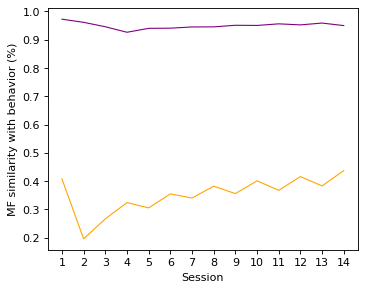

In [110]:
from matplotlib import pyplot as plt

# Escape time across training plot

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="second"]

df3["session"] = df3["session"].astype(np.int64)
df2 = df3.groupby("session").mean()
df2 = df2.reset_index()
df2["session"] = df2["session"]+3

df3 = df.reset_index()
df3 = df3[np.logical_and(df3["cond"]!="test", df3["cond"]!="extinction")]

df3 = df3[df3["stage"]=="first"]
df3["session"] = df3["session"].astype(np.int64)
df1 = df3.groupby("session").mean()
df1 = df1.reset_index()

df4 = df1.append(df2, ignore_index=True)
df4 = df4.groupby(["session", "agent"]).mean()


plt.figure(figsize=(5, 4), dpi=80)
df4= df4.reset_index()
df4.index += 1 
df4["Qcombsr"].plot(color="orange", xlabel="Session", ylabel="SR similarity with behavior (%)", linewidth=1.)
df4["Qcombmf"].plot(color="purple", xlabel="Session", ylabel="MF similarity with behavior (%)", linewidth=1.)

plt.xticks(range(1,15))



In [111]:
from scipy import stats
#PROXIMAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df4[df4["session"]<7]["Qcombmf"], df4[df4["session"]>=7]["Qcombmf"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=1.4734693877550953, pvalue=0.22479909925003677)


In [112]:
from scipy import stats
#PROXIMAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df4[df4["session"]<7]["Qcombsr"], df4[df4["session"]>=7]["Qcombsr"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=6.208163265306119, pvalue=0.01271625035507077)


In [113]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
#df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle"]).mean()

#df4 = df4.reset_index()


Y = df4['Qcombmf']
X = df4[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombmf   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.083
Method:                 Least Squares   F-statistic:                  0.005782
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.941
Time:                        18:39:43   Log-Likelihood:                 43.813
No. Observations:                  14   AIC:                            -83.63
Df Residuals:                      12   BIC:                            -82.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9493      0.006    163.770      0.000       0.937       0.962
session     5.763e-05      0.001      0.076      0.941      -0.002       0.002
==============================================================================
Omnibus:                        1.620   Durbin-Watson:                   0.739
Prob(Omnibus):                  0.445   Jarque-Bera (JB):                0.196
Skew:                           0.058   Prob(JB):                        0.907
Kurtosis:                       3.568   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE
#df2 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby(["angle"]).mean()

#df4 = df4.reset_index()


Y = df4['Qcombsr']
X = df4[["session"]]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qcombsr   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     9.246
Date:                Tue, 21 Dec 2021   Prob (F-statistic):             0.0103
Time:                        18:39:48   Log-Likelihood:                 23.082
No. Observations:                  14   AIC:                            -42.16
Df Residuals:                      12   BIC:                            -40.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2871      0.025     11.265      0.000       0.232       0.343
session        0.0101      0.003      3.041      0.010       0.003       0.017
==============================================================================
Omnibus:                        5.597   Durbin-Watson:                   2.267
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                2.687
Skew:                           0.487   Prob(JB):                        0.261
Kurtosis:                       4.912   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Evolution of MF weights

In [116]:
df12["distance_prox"] = df12.apply(lambda row: calculateDistance((row.proximal_posx, row.proximal_posy), coords[row.state]), axis=1)
df12["distance_dist"] = df12.apply(lambda row: calculateDistance(coords[90], coords[row.state]), axis=1)
df12["distance_prox"] = df12["distance_prox"].astype(int)
df12["distance_dist"] = df12["distance_dist"].astype(int)

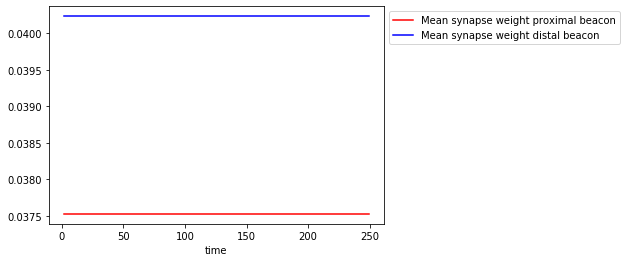

In [117]:
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_prox_mean"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["syn_dist_mean"].plot(color="b")
plt.legend(["Mean synapse weight proximal beacon", "Mean synapse weight distal beacon"],  bbox_to_anchor=(1.0, 1.0))

In [118]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("agent").mean()["syn_dist_mean"], df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("agent").mean()["syn_prox_mean"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=116.05540895522392, pvalue=4.622008777072405e-27)


Evolution of DIST/PROX selection rate and variance

Text(0, 0.5, 'Selection rate (%)')

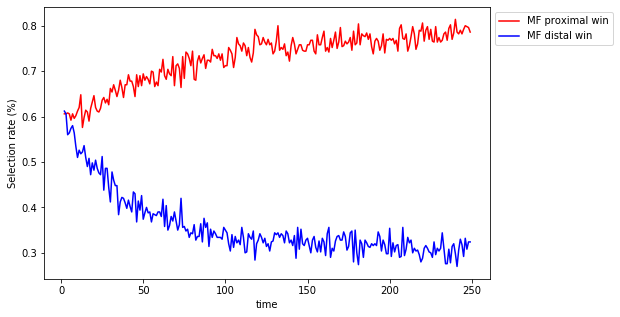

In [119]:
fig, ax = plt.subplots(figsize=(8,5))
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["Qcombprox"].plot(color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("time").mean()["Qcombdist"].plot(color="b")
plt.legend(["MF proximal win", "MF distal win"],  bbox_to_anchor=(1.0, 1.0))
ax.set_ylabel("Selection rate (%)")

In [120]:
from scipy import stats
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>50, df12["time"]<250)].groupby("agent").mean()["Qcombprox"], df12[np.logical_and(df12["time"]>50, df12["time"]<250)].groupby("agent").mean()["Qcombdist"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=149.01837389276005, pvalue=2.8413477394316017e-34)


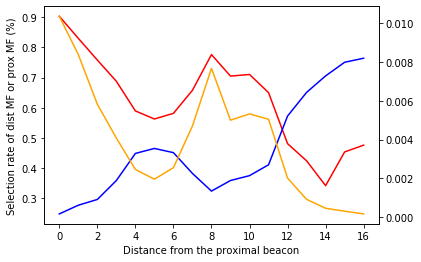

In [121]:
fig, ax = plt.subplots(1, 1)
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()["Qcombprox"].plot(ax=ax, color="r")
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()["Qcombdist"].plot(ax=ax, color="b")
#plt.legend(["proximal octant", "distal octant", "mean reward", "SR win", "MF win"],  bbox_to_anchor=(1.0, 1.0))
ax2 = ax.twinx()
df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()["var_prox"].plot(ax=ax2,color="orange")

ax.set_ylabel("Selection rate of dist MF or prox MF (%)")
ax.set_xlabel("Distance from the proximal beacon")
#plt.legend(["proximal octant", "distal octant", "mean reward", "SR win", "MF win"],  bbox_to_anchor=(1.0, 1.0))

plt.draw()

In [122]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df14 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()
df14=df14.reset_index()

Y = df14["Qcombprox"]
X = df14["distance_prox"]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Qcombprox   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     23.73
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           0.000203
Time:                        18:40:21   Log-Likelihood:                 16.285
No. Observations:                  17   AIC:                            -28.57
Df Residuals:                      15   BIC:                            -26.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8137      0.046     17.728      0.000       0.716       0.912
distance_prox    -0.0238      0.005     -4.871      0.000      -0.034      -0.013
==============================================================================
Omnibus:                        2.557   Durbin-Watson:                   0.648
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                1.094
Skew:                           0.043   Prob(JB):                        0.579
Kurtosis:                       1.760   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df14 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()
df14=df14.reset_index()

Y = df14["Qcombdist"]
X = df14["distance_prox"]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Qcombdist   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     40.19
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           1.33e-05
Time:                        18:40:26   Log-Likelihood:                 17.904
No. Observations:                  17   AIC:                            -31.81
Df Residuals:                      15   BIC:                            -30.14
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2359      0.042      5.653      0.000       0.147       0.325
distance_prox     0.0282      0.004      6.339      0.000       0.019       0.038
==============================================================================
Omnibus:                        2.820   Durbin-Watson:                   0.376
Prob(Omnibus):                  0.244   Jarque-Bera (JB):                1.937
Skew:                          -0.649   Prob(JB):                        0.380
Kurtosis:                       1.976   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
# LINEAR REGRESSION ON ESCAPE TIME TRAINING STAGE

df14 = df12[np.logical_and(df12["time"]>1, df12["time"]<250)].groupby("distance_prox").mean()
df14=df14.reset_index()
df14["var_prox"] = df14["var_prox"]*200

Y = df14["var_prox"]
X = df14["distance_prox"]

X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               var_prox   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     15.53
Date:                Tue, 21 Dec 2021   Prob (F-statistic):            0.00131
Time:                        18:40:30   Log-Likelihood:                -8.8516
No. Observations:                  17   AIC:                             21.70
Df Residuals:                      15   BIC:                             23.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.4681      0.201      7.291      0.000       1.039       1.897
distance_prox    -0.0846      0.021     -3.941      0.001      -0.130      -0.039
==============================================================================
Omnibus:                        0.843   Durbin-Watson:                   0.601
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.705
Skew:                           0.142   Prob(JB):                        0.703
Kurtosis:                       2.044   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Variance')

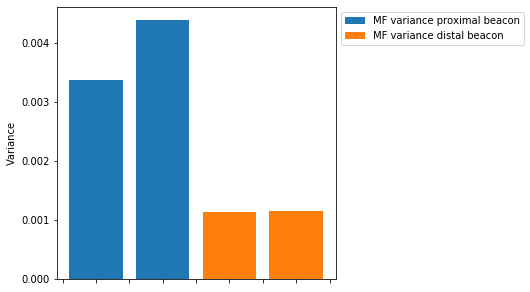

In [125]:

fig, ax = plt.subplots(figsize=(5,5))
plt.bar(x=[1,2], height=[df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby("state").mean()["var_prox"].mean(),df12[np.logical_and(df12["time"]>125, df12["time"]<250)].groupby("state").mean()["var_prox"].mean()])

plt.bar(x=[3,4], height=[df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby("state").mean()["var_dist"].mean(),df12[np.logical_and(df12["time"]>125, df12["time"]<250)].groupby("state").mean()["var_dist"].mean()])
#ax.legend(labels=['Proximal MF'], bbox_to_anchor=(1., 1.2))
plt.legend(["MF variance proximal beacon", "MF variance distal beacon"],  bbox_to_anchor=(1.0, 1.0))
ax.set_xticklabels(["", "", "", ""], rotation=70)
ax.set_ylabel("Variance")

In [126]:
from scipy import stats
#PROXIMAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_prox"], df12[np.logical_and(df12["time"]>1, df12["time"]>125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_prox"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=57.15125970149256, pvalue=4.035492834907646e-14)


In [127]:
from scipy import stats
# DISTAL
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df12[np.logical_and(df12["time"]>1, df12["time"]<125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_dist"], df12[np.logical_and(df12["time"]>1, df12["time"]>125)].groupby(["agent", "state"]).mean().groupby("agent").mean()["var_dist"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=4.172513432835785, pvalue=0.041084808469699884)


#### MF Variance NEAR DISTAL/PROXIMAL

In [128]:
from scipy.stats import entropy
df12["var_prox"] = df12.apply(lambda row: np.array([row.Qprox0, row.Qprox1, row.Qprox2, row.Qprox3, row.Qprox4, row.Qprox5]).var(), axis=1)
df12["var_dist"] = df12.apply(lambda row: np.array([row.Qdist0, row.Qdist1, row.Qdist2, row.Qdist3, row.Qdist4, row.Qdist5]).var(), axis=1)


In [129]:
df12["distance1"] = df12.apply(lambda row: calculateDistance(coords[75], coords[row.state]), axis=1)
df12["distance_group1"] = df12.apply(lambda row: row.distance1 > 3, axis=1)
df12["distance_group1"]=df12['distance_group1'].replace([True, False], ["d>30cm", 'd<30cm'])

In [130]:
df3=df12
df7 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby("state").mean()
df8 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby(["state", "distance_group1"]).mean()

In [131]:
# number of state where variance SR > variance MF
df7["ratio_prox_dist"] = df7["var_prox"]/df7["var_dist"]
df7[df7["ratio_prox_dist"] < 1]["ratio_prox_dist"].count()
df8["ratio_prox_dist"] = df8["var_prox"]/df8["var_dist"]
df8[df8["ratio_prox_dist"] < 1]["ratio_prox_dist"].count()

136

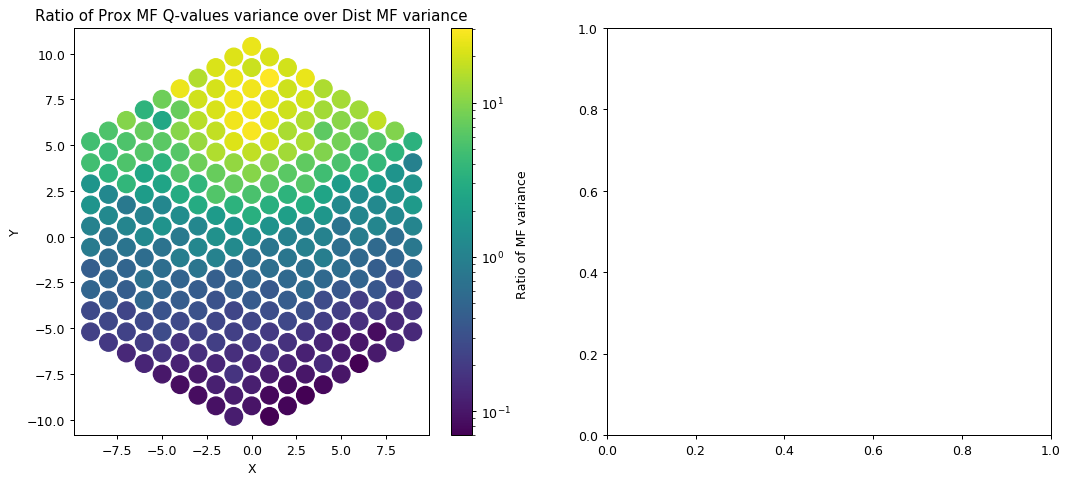

In [132]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["var_prox"][cpt]/df7["var_dist"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z, norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("Ratio of Prox MF Q-values variance over Dist MF variance")
plt.colorbar(im, label="Ratio of MF variance ",ax = axs[0])


In [133]:
from scipy import stats
df8=df8.reset_index()
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df8[df8["distance_group1"]=="d>30cm"]["ratio_prox_dist"], df8[df8["distance_group1"]=="d<30cm"]["ratio_prox_dist"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=43.82980429013719, pvalue=3.582083947403956e-11)


#### MF ENTROPY NEAR DISTAL/PROXIMAL

In [134]:
df12["distance2"] = df12.apply(lambda row: calculateDistance(coords[75], coords[row.state]), axis=1)
df12["distance_group2"] = df12.apply(lambda row: row.distance2 > 3, axis=1)
df12["distance_group2"]=df12['distance_group2'].replace([True, False], ["d>30cm", 'd<30cm'])

In [135]:
df3=df12
df7 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby("state").mean()
df8 = df3[np.logical_and(np.logical_or(df3["angle"]==180, df3["angle"]==180), df3["agent"]>=0)].groupby(["state", "distance_group2"]).mean()

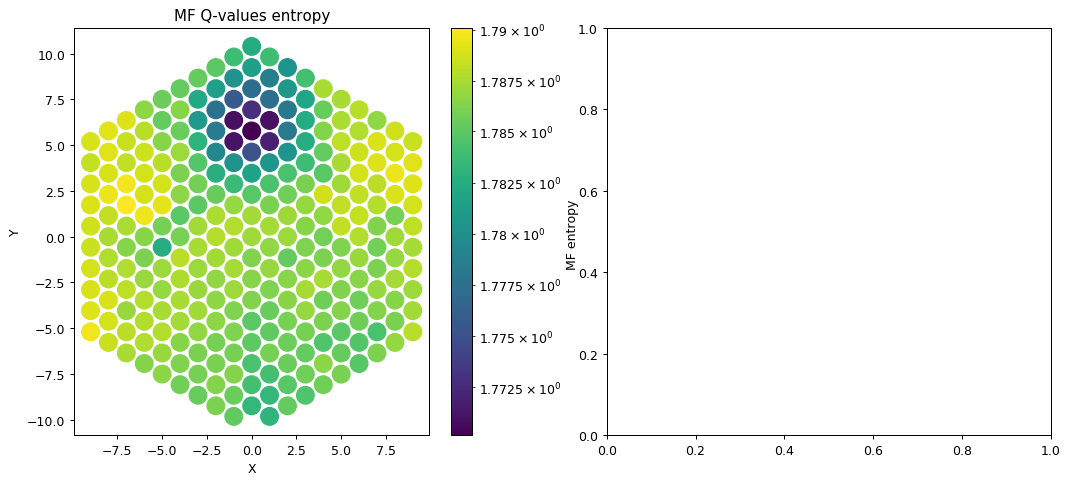

In [136]:
import matplotlib
from matplotlib import pyplot as plt
x = []
y = []
z = []
cpt=0
for i in range(270):
    try:
        z.append(df7["entro_mf"][cpt])
        x.append(coords[i][0])
        y.append(coords[i][1])
    except:
        z.append(0)
        x.append(coords[i][0])
        y.append(coords[i][1])
        pass
    cpt+=1
    
#im = plt.scatter(x, y, 100, c=z, norm=matplotlib.colors.LogNorm())
fig, axs = plt.subplots(1, 2,figsize=(14, 6), dpi=90, )

im = axs[0].scatter(x, y, 200, c=z, norm=matplotlib.colors.LogNorm())
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("MF Q-values entropy")
plt.colorbar(im, label="MF entropy ",ax = axs[0])


In [137]:
from scipy import stats
df8=df8.reset_index()
print("Computing non parametric ANOVA on trial...")
print(stats.kruskal(df8[df8["distance_group2"]=="d>30cm"]["entro_mf"], df8[df8["distance_group2"]=="d<30cm"]["entro_mf"]))

Computing non parametric ANOVA on trial...
KruskalResult(statistic=52.14913202122955, pvalue=5.144158490677102e-13)
